In [155]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
# Get Data

In [157]:
root_path = "WESAD"
zip_label = "_E4_Data.zip"
E4_label = "_E4_Data"

In [158]:
pacient_state = {
    0: "Not Defined/Transient",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Error/Not Labeled"
}

In [159]:
chest_signal_available = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']

In [160]:
subjects_available = os.listdir(root_path)

subjects_available

['S5',
 'S2',
 'S3',
 'S4',
 '.DS_Store',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

In [161]:
try:
    subjects_available.remove(".DS_Store")
except:
    print(subjects_available)

print(subjects_available)

['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S8', 'S6', 'S7', 'S9', 'S13', 'S14', 'S15']


In [162]:
def get_input_chest_data(subjects_list):
    
    chest_df_list = []
    
    for subject in subjects_list:
        
        pkl_path = os.path.join(root_path, subject, subject + ".pkl")
        f=open(pkl_path,'rb')
        data=pickle.load(f,encoding='latin1')
        
        index_df = [i for i in range(1, len(data["label"]) + 1)]

        chest_data = {
            body_signal: data["signal"]["chest"][body_signal].reshape(len(data["signal"]["chest"][body_signal]),)
            for body_signal in chest_signal_available
        }
        chest_data["label_id"] = [label if (label >= 0) and (label < 6) else 5 for label in data["label"]]
        chest_data["label"] = [pacient_state[label] if (label >= 0) and (label < 6) else pacient_state[5] for label in data["label"]]
        chest_data["subject"] = data["subject"]

        chest_df_list.append(pd.DataFrame(chest_data, index = index_df))
        
    return chest_df_list

In [163]:
input_chest_data = get_input_chest_data(subjects_available)

# Investigating Data

In [164]:
sample_df = input_chest_data[-1]

sample_df.sample(20)

,ECG,EMG,EDA,Temp,Resp,label_id,label,subject
1232499,-0.036850,-0.000504,2.444077,33.932678,1.020813,3,Amusement,S15
2503491,-0.053879,-0.020920,3.517151,34.472961,4.273987,2,Stress,S15
1768689,1.136490,-0.047653,2.992630,34.066589,2.760315,4,Meditation,S15
392162,-0.190292,0.005081,1.712036,33.714050,2.032471,1,Baseline,S15
1611622,0.675522,0.026184,2.870941,33.958527,1.902771,4,Meditation,S15
1883425,0.119659,-0.002060,3.013992,34.144348,-0.733948,0,Not Defined/Transient,S15
792907,-0.017715,-0.001373,2.061844,33.714050,1.869202,1,Baseline,S15
867183,-0.162003,-0.001556,2.141190,33.814178,1.603699,1,Baseline,S15
780421,-0.094894,0.000961,2.051163,33.738312,-2.362061,1,Baseline,S15
1535047,-0.097229,-0.003067,2.706528,34.054443,4.380798,0,Not Defined/Transient,S15


In [165]:
sample_df["label_id"].value_counts()

0    1457401
1     822500
4     555799
2     480200
3     260400
5     100100
Name: label_id, dtype: int64

In [166]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3676400 entries, 1 to 3676400
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ECG       float64
 1   EMG       float64
 2   EDA       float64
 3   Temp      float32
 4   Resp      float64
 5   label_id  int64  
 6   label     object 
 7   subject   object 
dtypes: float32(1), float64(4), int64(1), object(2)
memory usage: 238.4+ MB


In [167]:
sample_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,3676400.0,0.001106,0.288565,-1.257111,-0.100937,-0.018265,0.020691,1.499496
EMG,3676400.0,-0.002721,0.018240,-0.379715,-0.010803,-0.002335,0.005081,0.500931
EDA,3676400.0,2.909373,0.837835,1.250076,2.148819,3.001404,3.648758,4.318237
Temp,3676400.0,34.081013,0.346502,33.010864,33.815674,34.054443,34.407104,34.907837
Resp,3676400.0,0.055039,4.501873,-22.190857,-2.311707,-0.172424,2.561951,28.750610
label_id,3676400.0,1.438308,1.553870,0.000000,0.000000,1.000000,2.000000,5.000000


In [168]:
sample_df["label_id"].unique()

array([0, 1, 5, 3, 4, 2])

In [169]:
unique_values, counts = np.unique(sample_df["label_id"], axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [1457401  822500  480200  260400  555799  100100]
[0 1 2 3 4 5] [0.39642068 0.2237243  0.13061691 0.07083016 0.15118023 0.02722772]


In [170]:
def plot_signal_label(df, sample_rate=700):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)

    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ECG", "label_id"], ax=ax1)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["EMG", "label_id"], ax=ax2)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["EDA", "label_id"], ax=ax3)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["Temp", "label_id"], ax=ax4)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["Resp", "label_id"], ax=ax5)

In [171]:
def plot_corr(df, correlation_type="pearson"):

    corr_df  = df.corr(correlation_type)

    fig, ax_corr = plt.subplots(1, 1, figsize=(50,20))
    sns.heatmap(corr_df, annot=True, ax=ax_corr)


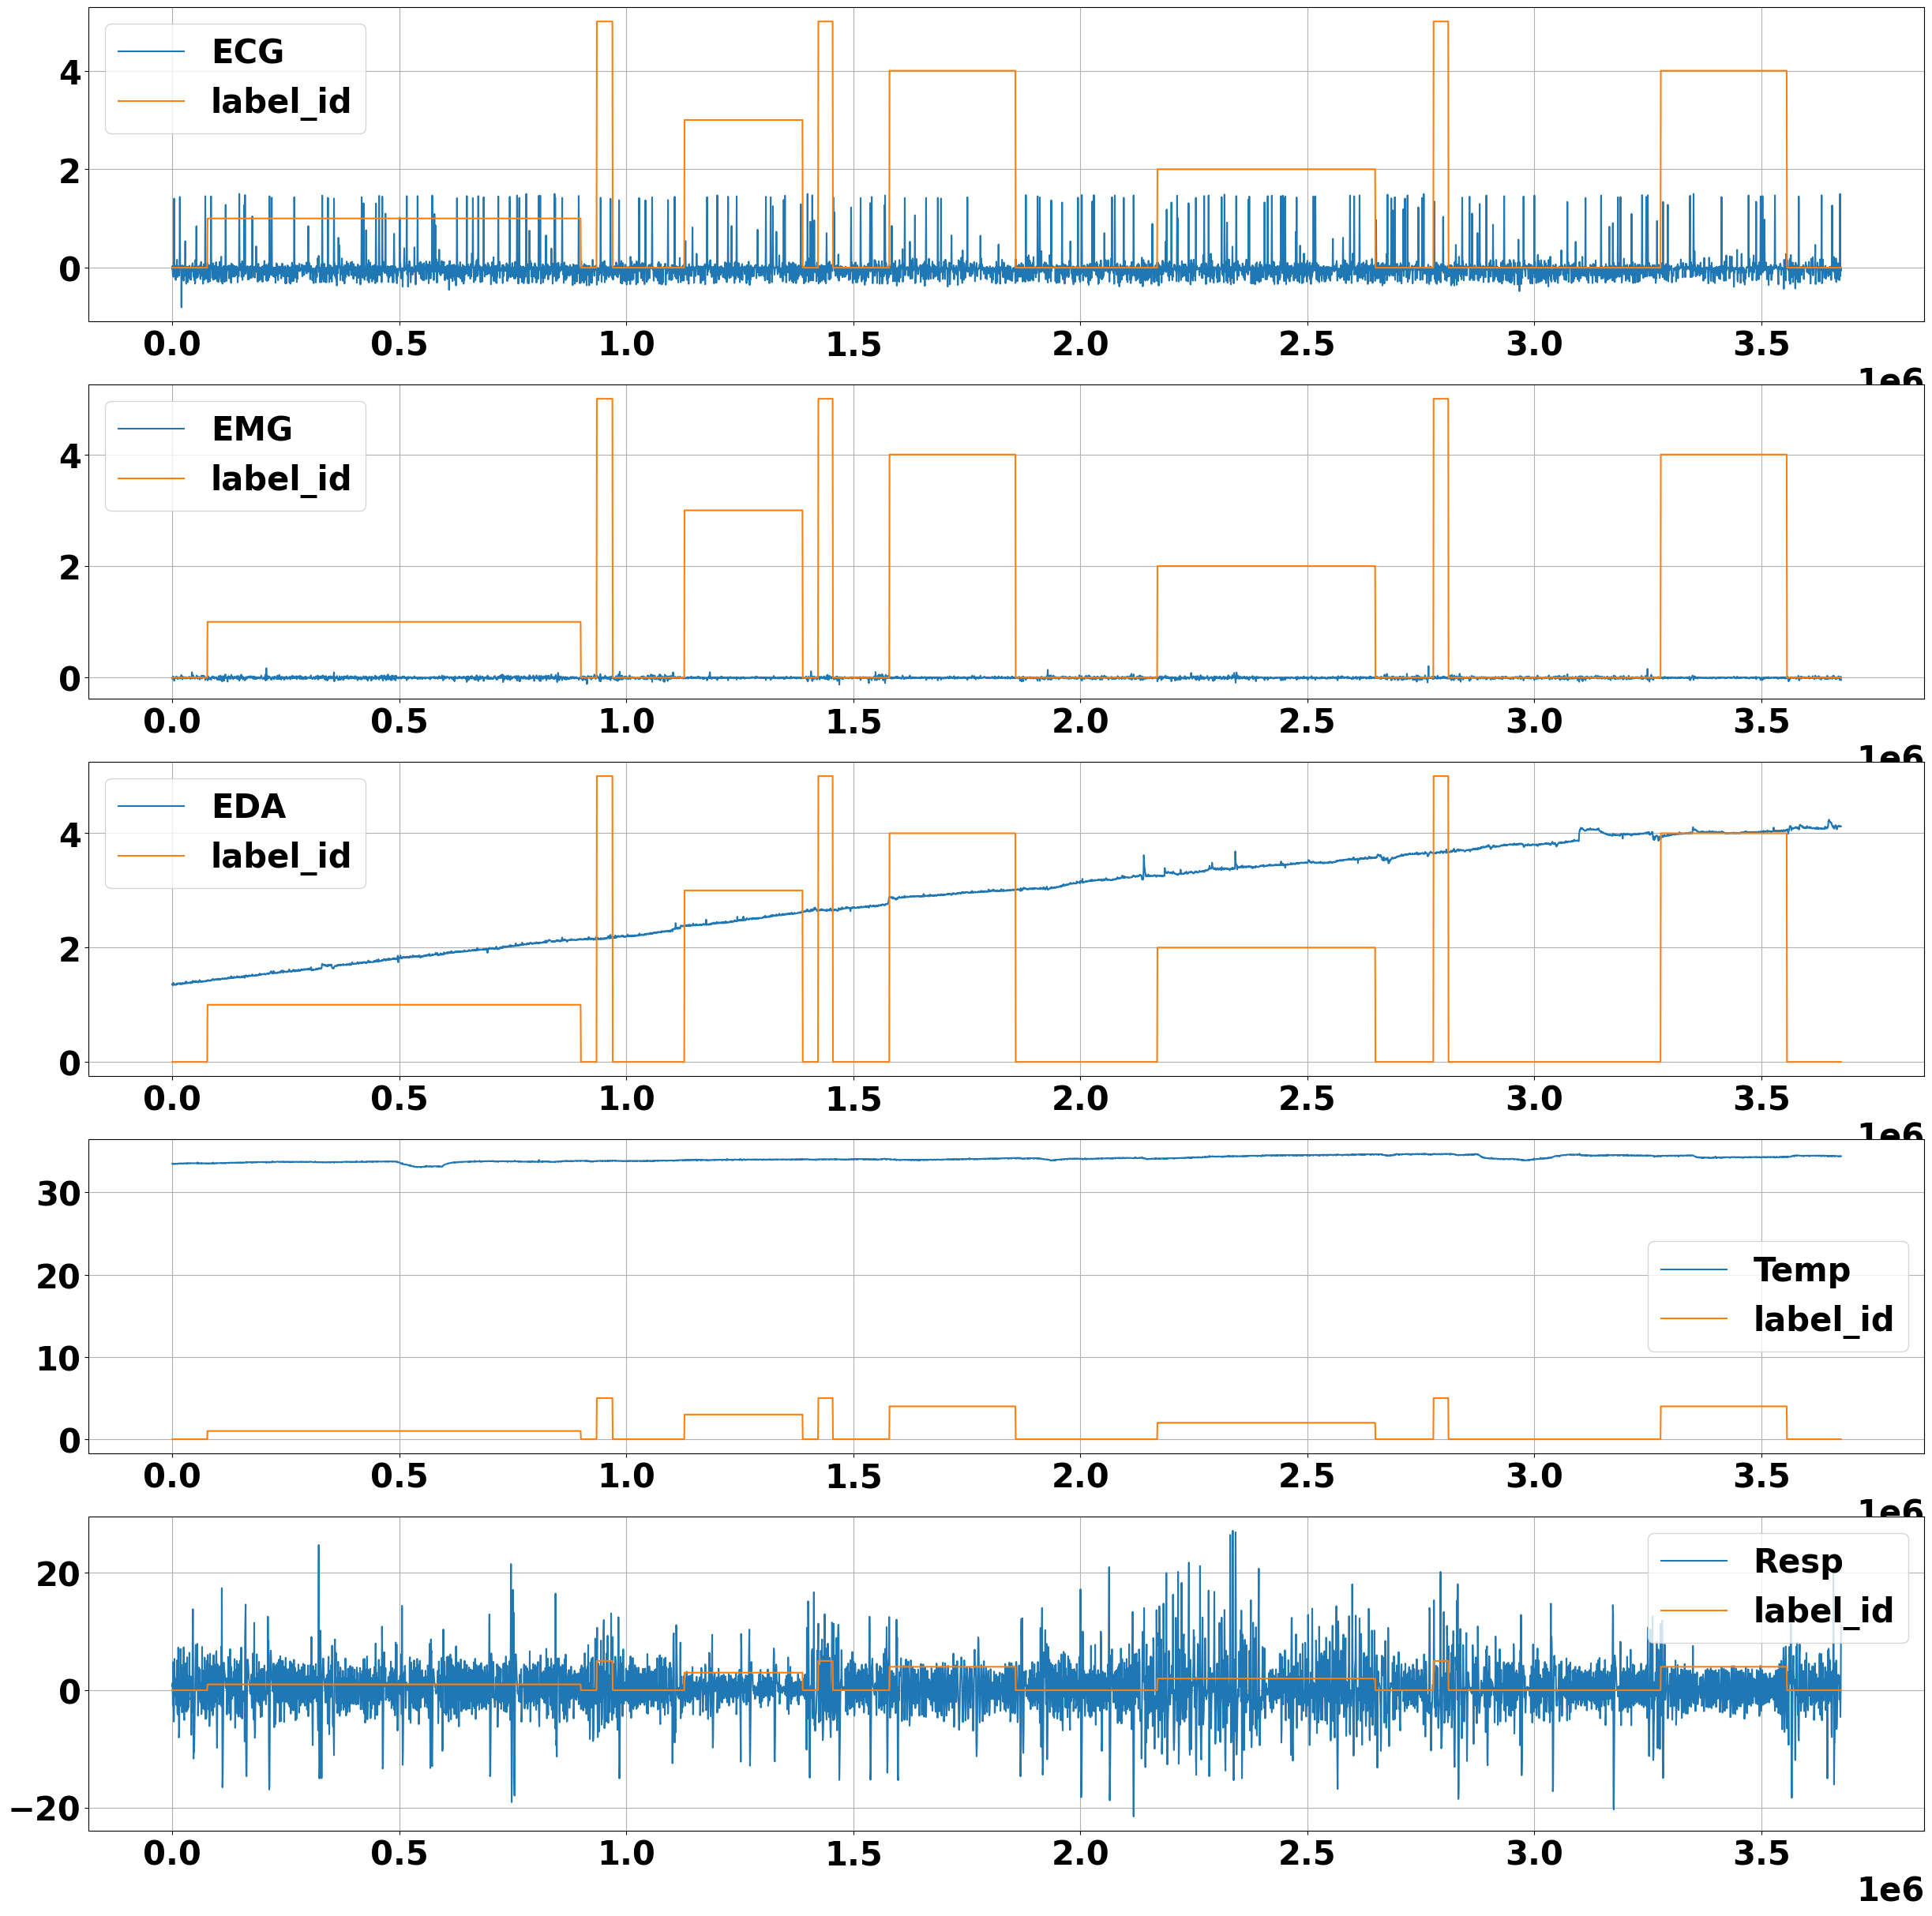

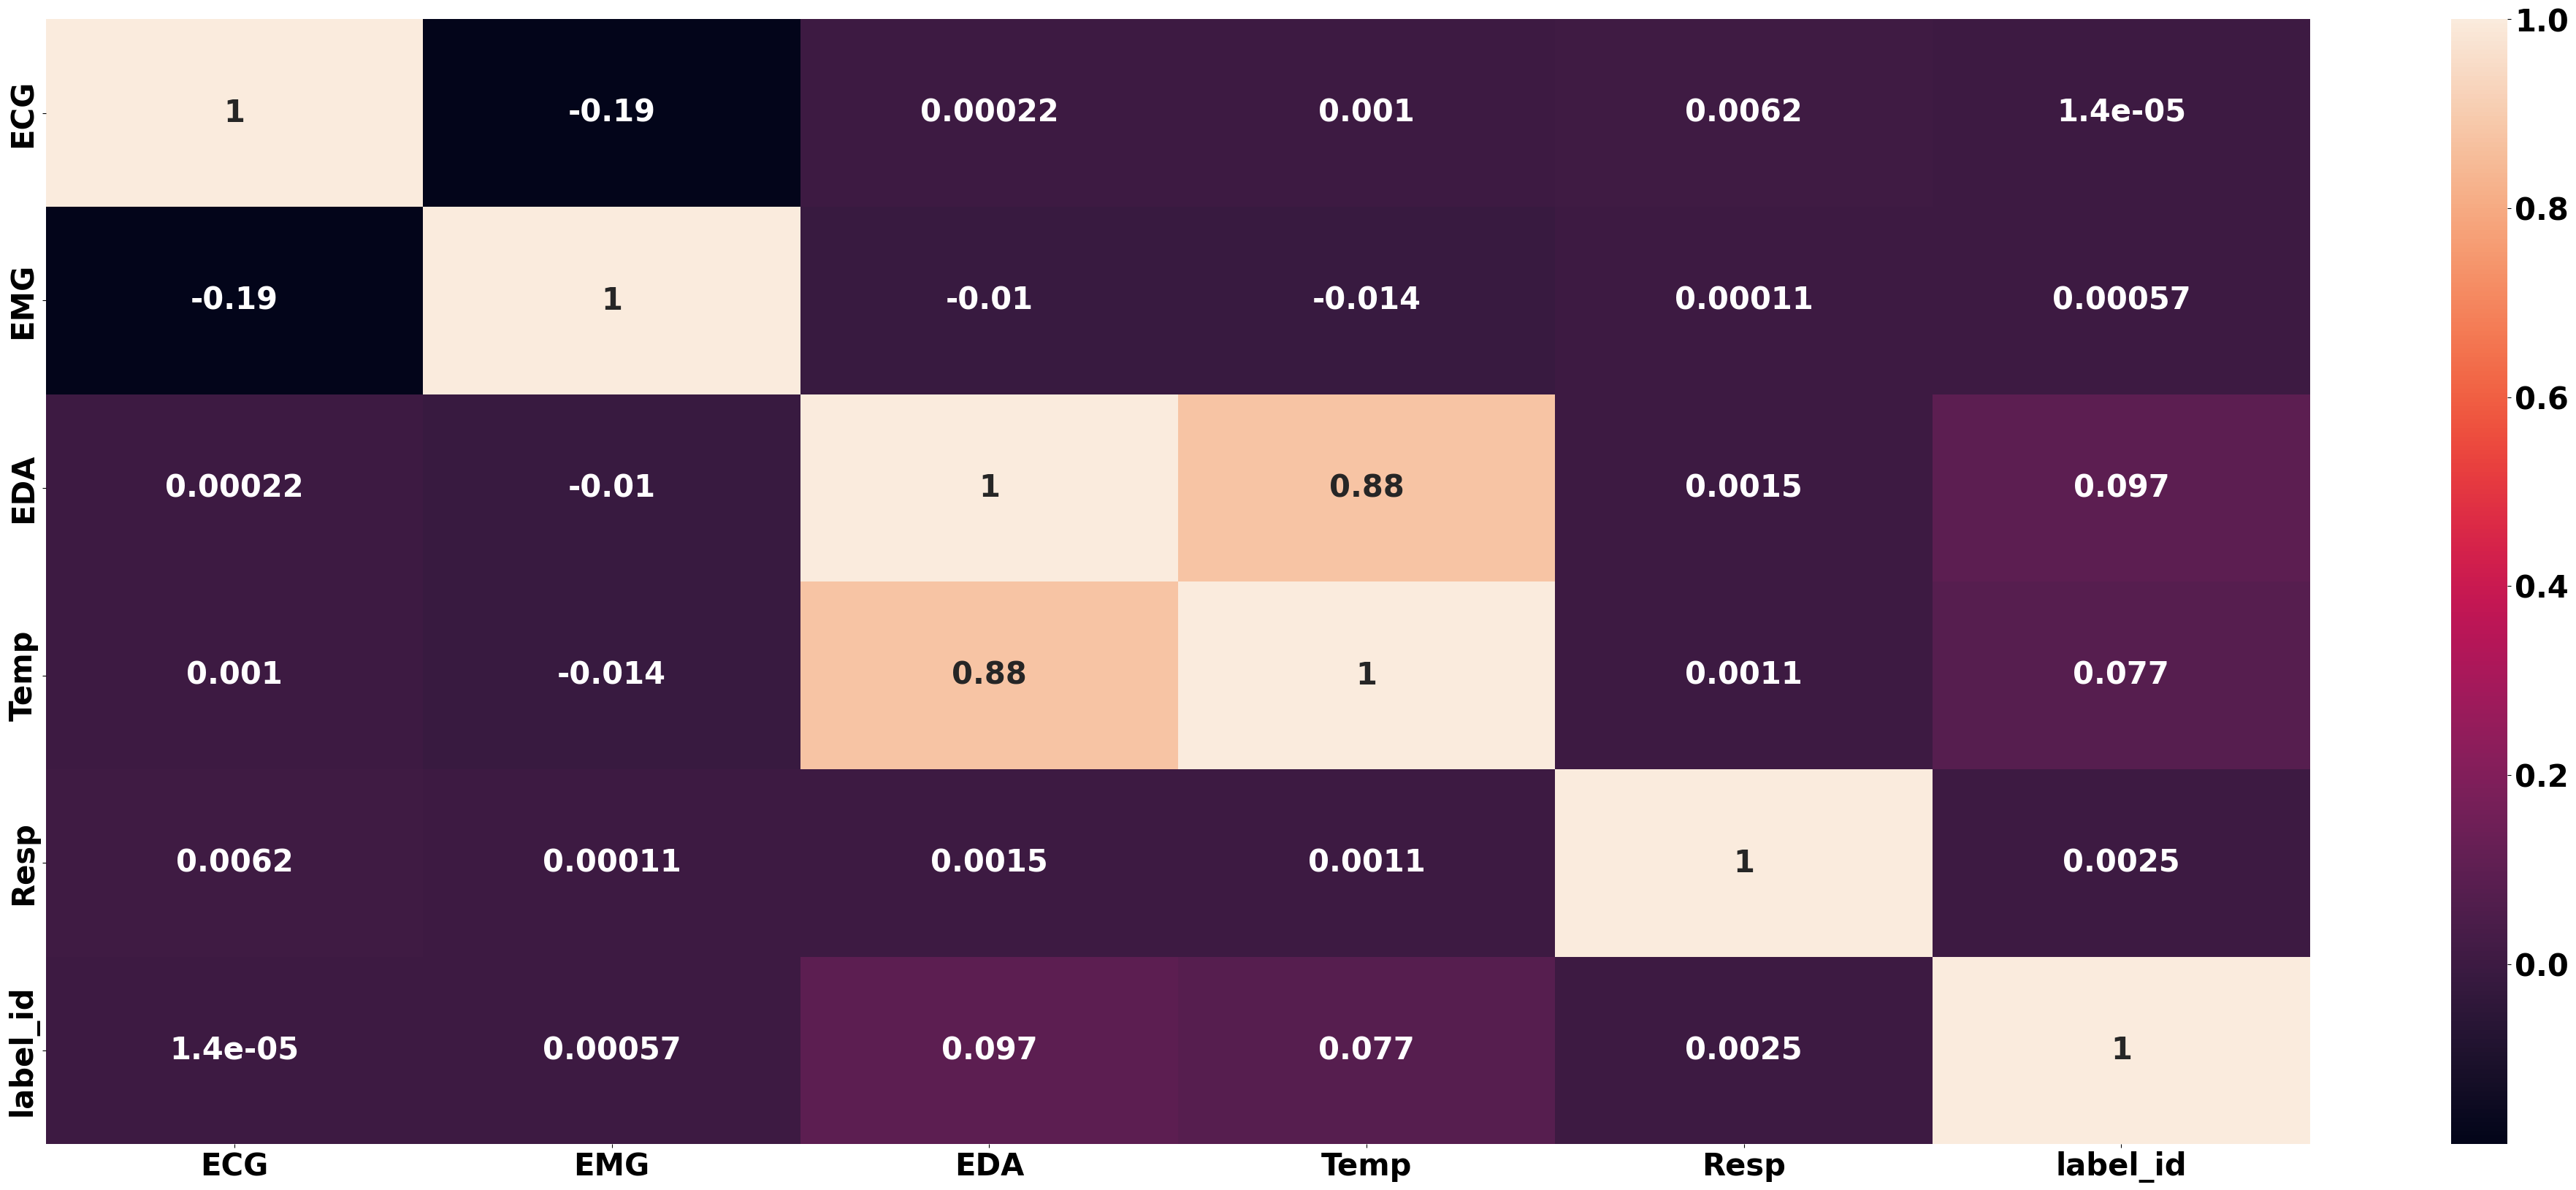

In [172]:
plot_signal_label(sample_df)
plot_corr(sample_df)

## Oversample Data Analysis

In [173]:
from imblearn.over_sampling import SMOTE

In [174]:
oversample = SMOTE()

In [175]:
sample_df[chest_signal_available][::700]

,ECG,EMG,EDA,Temp,Resp
1,-0.025543,-0.016159,1.362228,33.493042,0.691223
701,0.036621,0.010574,1.345062,33.471863,1.240540
1401,-0.157745,-0.003891,1.361084,33.440155,-2.593994
2101,0.025131,0.020828,1.343918,33.480957,4.783630
2801,-0.185349,0.015198,1.384354,33.464294,-1.437378
...,...,...,...,...,...
3672901,0.027054,-0.041061,4.121780,34.362732,1.878357
3673601,1.499130,-0.006042,4.113388,34.411713,0.111389
3674301,-0.175186,0.005539,4.119110,34.405579,-4.570007
3675001,0.008652,0.020828,4.120255,34.410187,-0.196838


In [176]:
X, y = oversample.fit_resample(sample_df[chest_signal_available][::700], sample_df["label_id"][::700])

In [177]:
X

,ECG,EMG,EDA,Temp,Resp
0,-0.025543,-0.016159,1.362228,33.493042,0.691223
1,0.036621,0.010574,1.345062,33.471863,1.240540
2,-0.157745,-0.003891,1.361084,33.440155,-2.593994
3,0.025131,0.020828,1.343918,33.480957,4.783630
4,-0.185349,0.015198,1.384354,33.464294,-1.437378
...,...,...,...,...,...
12487,-0.054517,-0.013678,2.544887,33.992393,0.549204
12488,-0.142885,-0.024953,2.646680,34.032024,0.256440
12489,-0.090115,-0.008194,3.656769,34.683136,-1.749721
12490,-0.253821,-0.005604,2.659505,34.004990,2.015533


In [178]:
y.value_counts()

0    2082
1    2082
5    2082
3    2082
4    2082
2    2082
Name: label_id, dtype: int64

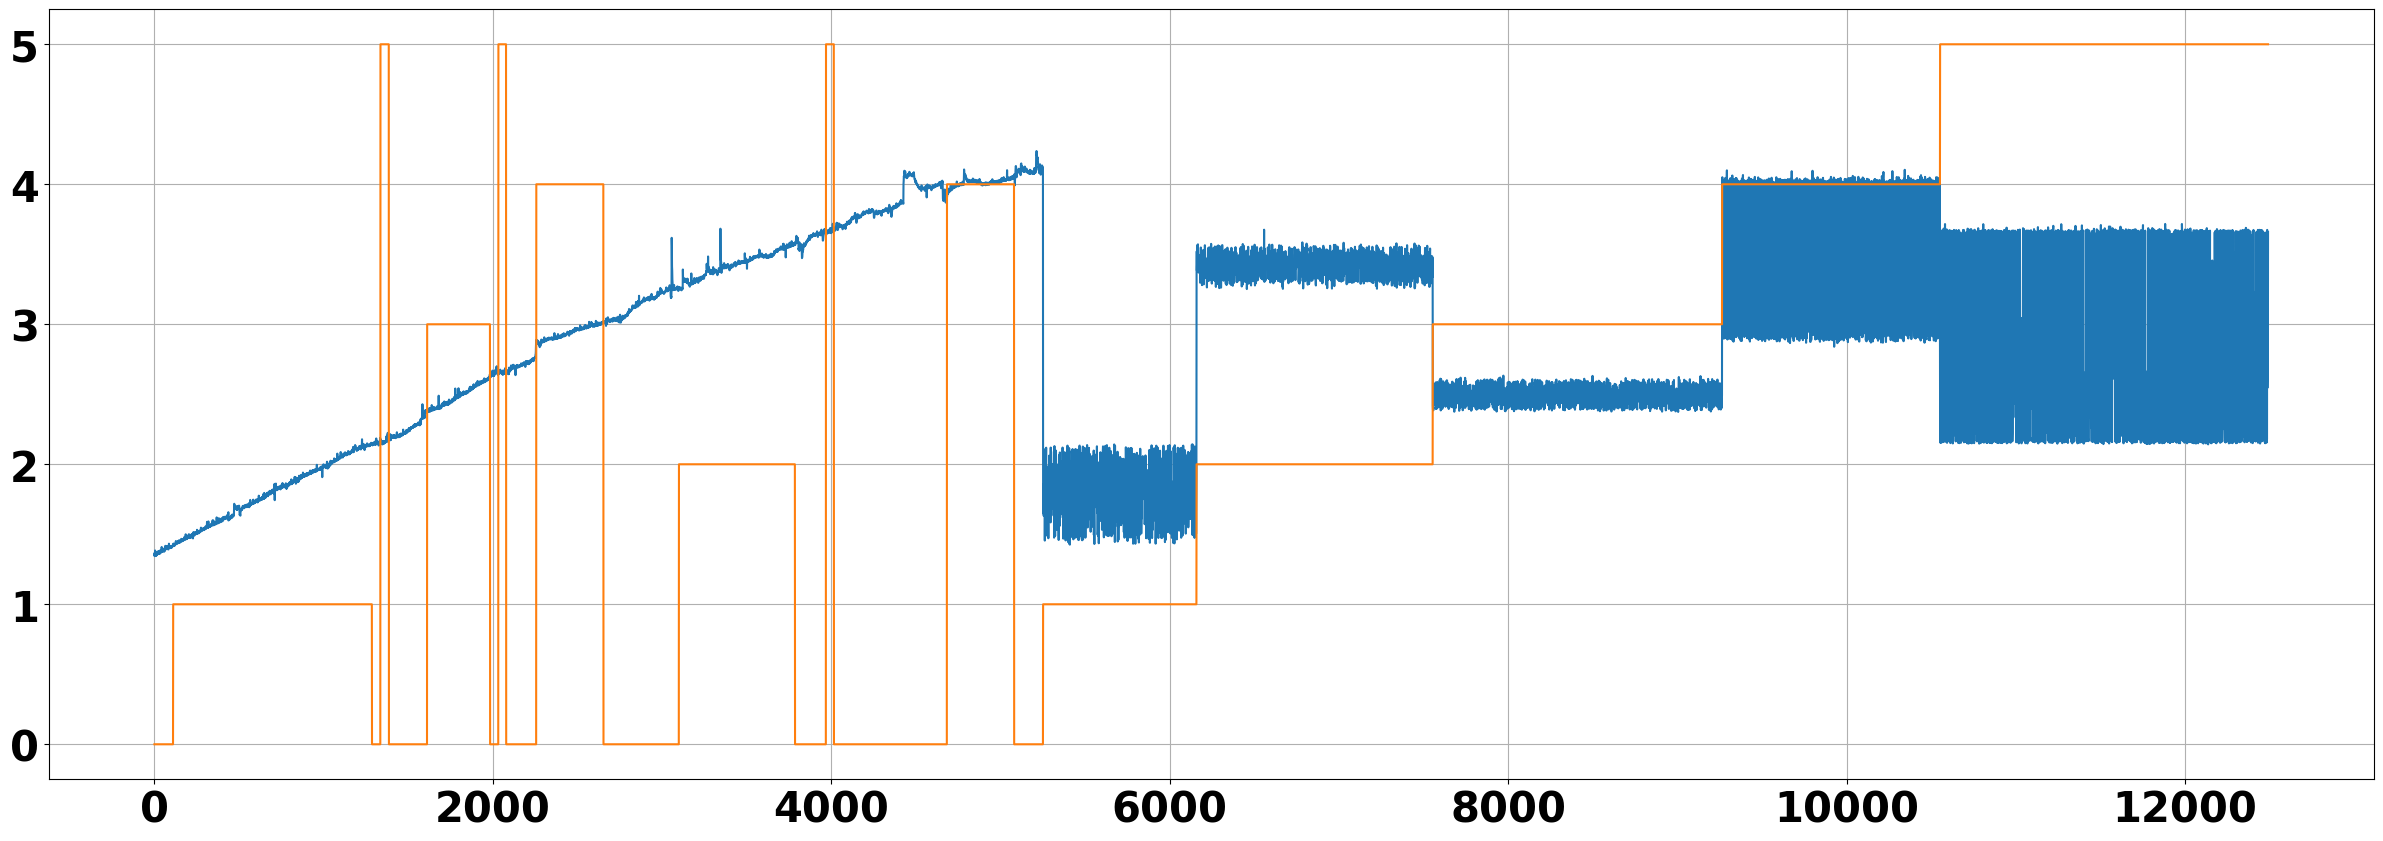

In [179]:
fig, ax1 = plt.subplots(figsize=(30,10))

ax1.plot(X["EDA"])
ax1.plot(y)
ax1.grid(True)

## Fourier Analsys

In [180]:
# from numpy.fft import fft, ifft, fftfreq
# from scipy import pi, signal, fftpack
# def annot_max(x, y, ax=None):
#     xmax = x[np.argmax(y)]
#     ymax = y.max()
#     text= "x={:.3f}, y={:.3f}".format(xmax, ymax) 
#     #text = f"{xmax=}, {ymax=}, (period: {1./xmax} days)" #Eh, Colab has Python 3.6 ... 
#     text = f"x={xmax:.3f}, y={ymax:.3f}, (period: {(1./xmax):.2f} )"
#     if not ax:
#         ax=plt.gca()
#     bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
#     arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
#     kw = dict(xycoords='data',textcoords="axes fraction",
#               arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
#     ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)
# def plot_fft(signal, signal_name="", f_rate = 700*7/10):
#     plt.rcdefaults()

#     nobs = len(signal)
#     signal_ft = np.abs(fft(signal))
#     signal_freq = fftfreq(nobs, 1/f_rate)

#     plt.figure(figsize=(20,2))
#     plt.plot(signal_freq[2:], signal_ft[2: ])
#     annot_max(signal_freq[2:], signal_ft[2: ])
#     plt.grid()

#     plt.ylabel(f"{signal_name}")
#     plt.xlabel('frequency')
#     plt.show()
# for signal in sample_df.columns:
#     if (signal != "label_id" and signal != "label" and signal != "subject"):
#         plot_fft(sample_df[signal], signal)
# for signal in sample_df.columns:
#     if (signal != "label_id" and signal != "label" and signal != "subject"):
#         plot_fft(sample_df[signal][::700], signal)
# for signal in sample_df.columns:
#     if (signal != "label_id" and signal != "label" and signal != "subject"):
#         plot_fft(sample_df[signal][::700][:60], signal)
# def plot_fft(signal, signal_name="", f_rate = 700*7/10):
#     plt.rcdefaults()

#     nobs = len(signal)
#     signal_ft = np.abs(fft(signal))
#     signal_freq = fftfreq(nobs, 1/f_rate)

#     plt.figure(figsize=(20,2))
#     plt.plot(signal_freq[2:], signal_ft[2: ])
#     annot_max(signal_freq[2:], signal_ft[2: ])
#     plt.grid()

#     plt.ylabel(f"{signal_name}")
#     plt.xlabel('frequency')
#     plt.show()
# def low_pass(s, threshold=2e4, f_rate = 700*7/10):
#     fourier = fft(s)
#     frequencies = fftfreq(s.size, f_rate)
#     fourier[frequencies > threshold] = 0
#     signal_ft = np.abs(fourier)

#     plt.figure(figsize=(20,2))
#     plt.plot(frequencies[2:], signal_ft[2: ])
#     annot_max(frequencies[2:], signal_ft[2: ])
#     plt.grid()
#     plt.show()

#     return np.real_if_close(ifft(fourier))
# plot_fft(sample_df["ECG"], "ECG")
# teste = low_pass(sample_df["ECG"], 6)
# teste
# plot_fft(low_pass(sample_df["ECG"], threshold = 6), "ECG")
# plot_fft(sample_df["ECG"], "ECG")
# fig = plt.figure(figsize=(40,14))
# plt.xlabel('time',fontsize=40, labelpad=25)
# plt.ylabel('EMG',fontsize=40, labelpad=25)
# plt.plot(sample_df["ECG"], linewidth=1)
# plt.plot(teste, linewidth=5)
# plt.legend(['Real value','FFT smoothing'], prop={'size': 20})
# plt.title('',fontsize=40, pad=30)

# plt.show()

# Cleaning Data

In [181]:
win_size = 60 # will represent 1 minute

def simple_rolling_z_score(x, window):
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z

In [182]:
def rolling_z_score(df, win_size):

    copy_df = df.copy()

    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        mean = df[slicer].mean()
        std = df[slicer].std(ddof=0)

        copy_df[slicer] = (df[slicer] - mean) / std

    return copy_df


In [183]:
clean_chest_data = []

for data_df in input_chest_data:

    # Resampling data choosing one point each 700 points
    resample_data_df = data_df[::700]

    # Separating features and targets
    X, y = resample_data_df[chest_signal_available], resample_data_df["label_id"]

    # Getting subject label
    subject_label = resample_data_df.pop("subject").to_numpy()[0]

    # Convert target to numpy
    target = y.to_numpy()

    # applying rolling score-z
    feature_df = rolling_z_score( X, win_size)

    clean_chest_data.append((feature_df, target, subject_label))

In [184]:
len(clean_chest_data), len(clean_chest_data[-1])

(15, 3)

In [185]:
clean_chest_data[-1][0].describe().T

,count,mean,std,min,25%,50%,75%,max
ECG,5252.0,-0.002976,0.979359,-3.719592,-0.370462,-0.073179,0.129873,6.704812
EMG,5252.0,0.003512,1.030576,-6.775860,-0.509309,0.011737,0.530964,6.987055
EDA,5252.0,-0.887871,1.077132,-6.692779,-1.567281,-1.048527,-0.426427,6.734528
Temp,5252.0,-0.245240,1.210026,-3.910494,-1.026268,-0.210484,0.580849,5.444746
Resp,5252.0,-0.002320,1.040725,-4.817611,-0.592017,-0.066059,0.635029,5.274090


In [186]:
clean_chest_data[-1][1].shape, clean_chest_data[-1][2]

((5252,), 'S15')

In [187]:
unique_values, counts = np.unique(clean_chest_data[-1][1], axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [2082 1175  686  372  794  143]
[0 1 2 3 4 5] [0.39642041 0.2237243  0.13061691 0.07083016 0.1511805  0.02722772]


In [188]:
unique_values, counts = np.unique(sample_df["label_id"], axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [1457401  822500  480200  260400  555799  100100]
[0 1 2 3 4 5] [0.39642068 0.2237243  0.13061691 0.07083016 0.15118023 0.02722772]


# Windowing

In [189]:
def get_most_repeted_element(np_array):
    (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
    most_repeted_element_index = np.where(counts == max(counts))
    return unique[most_repeted_element_index[0][0]]

def get_window_label(np_array, win_size = 60):
    return np.array([get_most_repeted_element(np_array[slice(i, win_size + i)]) for i in range(len(np_array) - win_size + 1)])

def get_windows_features(np_array, win_size = 60):
    return np.array([np_array[slice(i, win_size + i)] for i in range(len(np_array) - win_size + 1)])

In [190]:
# len(window_feature_test) windows with 60 rows and 5 columns

window_feature_test = get_windows_features(clean_chest_data[0][0].to_numpy())
window_feature_test.shape

(6199, 60, 5)

In [191]:
window_label_test = get_window_label(clean_chest_data[0][1])
window_label_test.shape

(6199,)

In [192]:
validation_data = clean_chest_data.pop()

In [193]:
validation_features = get_windows_features(validation_data[0].to_numpy())
validation_targets = get_window_label(validation_data[1])

In [194]:
validation_features.shape, validation_targets.shape

((5193, 60, 5), (5193,))

In [195]:
unique_values, counts = np.unique(validation_labels, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [2031 1174  685  371  792  140]
[0 1 2 3 4 5] [0.39110341 0.22607356 0.13190834 0.07144233 0.152513   0.02695937]


In [196]:
features = np.concatenate(tuple(get_windows_features(data[0].to_numpy()) for data in clean_chest_data), axis=0)
targets = np.concatenate(tuple(get_window_label(data[1]) for data in clean_chest_data), axis=0)

In [197]:
features.shape, targets.shape

((80790, 60, 5), (80790,))

# Model

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Activation, GRU, GaussianNoise, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import convert_to_tensor

import datetime

## Adjusting data for the model

To compare with wesade article, the model will classify only Baseline x Stress x Amusement

In [199]:
def remove_data(features, targets, label_id):
    indexes = np.where(targets == label_id)
    return np.delete(features, indexes, axis=0), np.delete(targets, indexes)

In [200]:
def update_labels(targets, old_label_id, new_label_id):
    '''baseline = 0, stress = 1, amusement = 2'''
    indexes = np.where(targets == old_label_id)
    targets[indexes] = new_label_id
    return targets

In [201]:
for label_id in [0, 4, 5]:
    features, targets = remove_data(features, targets, label_id)
features.shape, targets.shape

((30875, 60, 5), (30875,))

In [202]:
unique_values, counts = np.unique(targets, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[1 2 3] [16420  9266  5189]
[1 2 3] [0.53182186 0.30011336 0.16806478]


In [203]:
for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
    targets = update_labels(targets, old_label_id, new_label_id)
features.shape, targets.shape

((30875, 60, 5), (30875,))

In [204]:
unique_values, counts = np.unique(targets, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2] [16420  9266  5189]
[0 1 2] [0.53182186 0.30011336 0.16806478]


In [205]:
validation_features.shape, validation_labels.shape

((5193, 60, 5), (5193,))

In [206]:
for label_id in [0, 4, 5]:
    validation_features, validation_targets = remove_data(validation_features, validation_targets, label_id)
validation_features.shape, validation_targets.shape

((2230, 60, 5), (2230,))

In [207]:
for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
    validation_targets = update_labels(validation_targets, old_label_id, new_label_id)
validation_features.shape, validation_targets.shape

((2230, 60, 5), (2230,))

In [208]:
unique_values, counts = np.unique(targets, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2] [16420  9266  5189]
[0 1 2] [0.53182186 0.30011336 0.16806478]


In [209]:
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(targets), y = targets)
weights = {i : weights[i] for i in range(len(weights))}
weights

{0: 0.6267762890783597, 1: 1.1106914166486797, 2: 1.9833622406372455}

In [210]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, stratify=targets)

In [211]:
x_train.shape, x_test.shape

((18525, 60, 5), (12350, 60, 5))

In [212]:
y_train.shape, y_test.shape

((18525,), (12350,))

In [213]:
x_train_tensor = convert_to_tensor(x_train)
x_test_tensor = convert_to_tensor(x_test)
y_train_tensor = convert_to_tensor(y_train)
y_test_tensor = convert_to_tensor(y_test)

In [214]:
x_train_tensor.shape, x_test_tensor.shape

(TensorShape([18525, 60, 5]), TensorShape([12350, 60, 5]))

In [215]:
y_train_tensor.shape, y_test_tensor.shape

(TensorShape([18525]), TensorShape([12350]))

## Model

In [216]:
def lstm(model = None):
    model.add(GaussianNoise(0.1))
    model.add(LSTM(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(6))

def gru(model = None):
    model.add(GRU(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(GaussianNoise(0.5))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(3, activity_regularizer = L2(0.000001), bias_constraint = max_norm(3)))


In [217]:
# duas lstm uma dropout e uma dense
# testar uma GRU (trocar todas as LSTM por elas)


def create_model(has_activator, last_activation_layer, hidden_layer_type, optimizer):

    model = Sequential()
    hidden_layer_type(model)
    if has_activator:
        model.add(Activation(last_activation_layer))
    model.build()

    model.summary()

    model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = optimizer, #nadam or rmstrop
        metrics = ["sparse_categorical_accuracy", "accuracy"]
    )

    return model


In [218]:
models_to_test = {
    # "softmax_lstm_adam": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "blue",
    #     "layers": lstm,
    #     "optimizer": "adam",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # },
    # "softmax_lstm_nadam": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "red",
    #     "layers": lstm,
    #     "optimizer": "nadam",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # },
    # "softmax_lstm_rmsprop": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "green",
    #     "layers": lstm,
    #     "optimizer": "rmsprop",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # }
    "softmax_gru_adam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "yellow",
        "layers": gru,
        "optimizer": "adam",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_nadam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "magenta",
        "layers": gru,
        "optimizer": "nadam",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_rmsprop": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "cyan",
        "layers": gru,
        "optimizer": "rmsprop",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    }   
}

In [219]:
for model_name in models_to_test:

    has_activator = models_to_test[model_name]["has_activator"]
    activation_layer = models_to_test[model_name]["activator_layer"]
    hidden_layer = models_to_test[model_name]["layers"]
    optimizer = models_to_test[model_name]["optimizer"]
    
    

    model = create_model(has_activator, activation_layer, hidden_layer, optimizer)
    history = model.fit(
        x=x_train_tensor,
        y=y_train_tensor,
        validation_data=(x_test_tensor, y_test_tensor),
        epochs=100,
        shuffle=False,
        class_weight=weights,
        callbacks=models_to_test[model_name]["callbacks"]
    )

    # model.save(f"models/stress_detection_{model_name}")

    models_to_test[model_name]["history"] = history
    models_to_test[model_name]["model"] = model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 60, 128)           51840     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 60, 128)           0         
                                                                 
 gaussian_noise_3 (GaussianN  (None, 60, 128)          0         
 oise)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 60, 128)           0         
                                                                 
 flatten_3 (Flatten)         (None, 7680)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 23043     
                                                      

In [220]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x148b8f7f0>],
  'history': <keras.callbacks.History at 0x14914d880>,
  'model': <keras.engine.sequential.Sequential at 0x148ba9fa0>},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'nadam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x148b8f430>],
  'history': <keras.callbacks.History at 0x14a16e9a0>,
  'model': <keras.engine.sequential.Sequential at 0x147ac70a0>},
 'softmax_gru_rmsprop': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'cyan',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'rmsprop',
  'callbacks': [<keras.callbacks.TensorBoard at 0x148b8f730>],
  'history': <keras.callbacks.History a

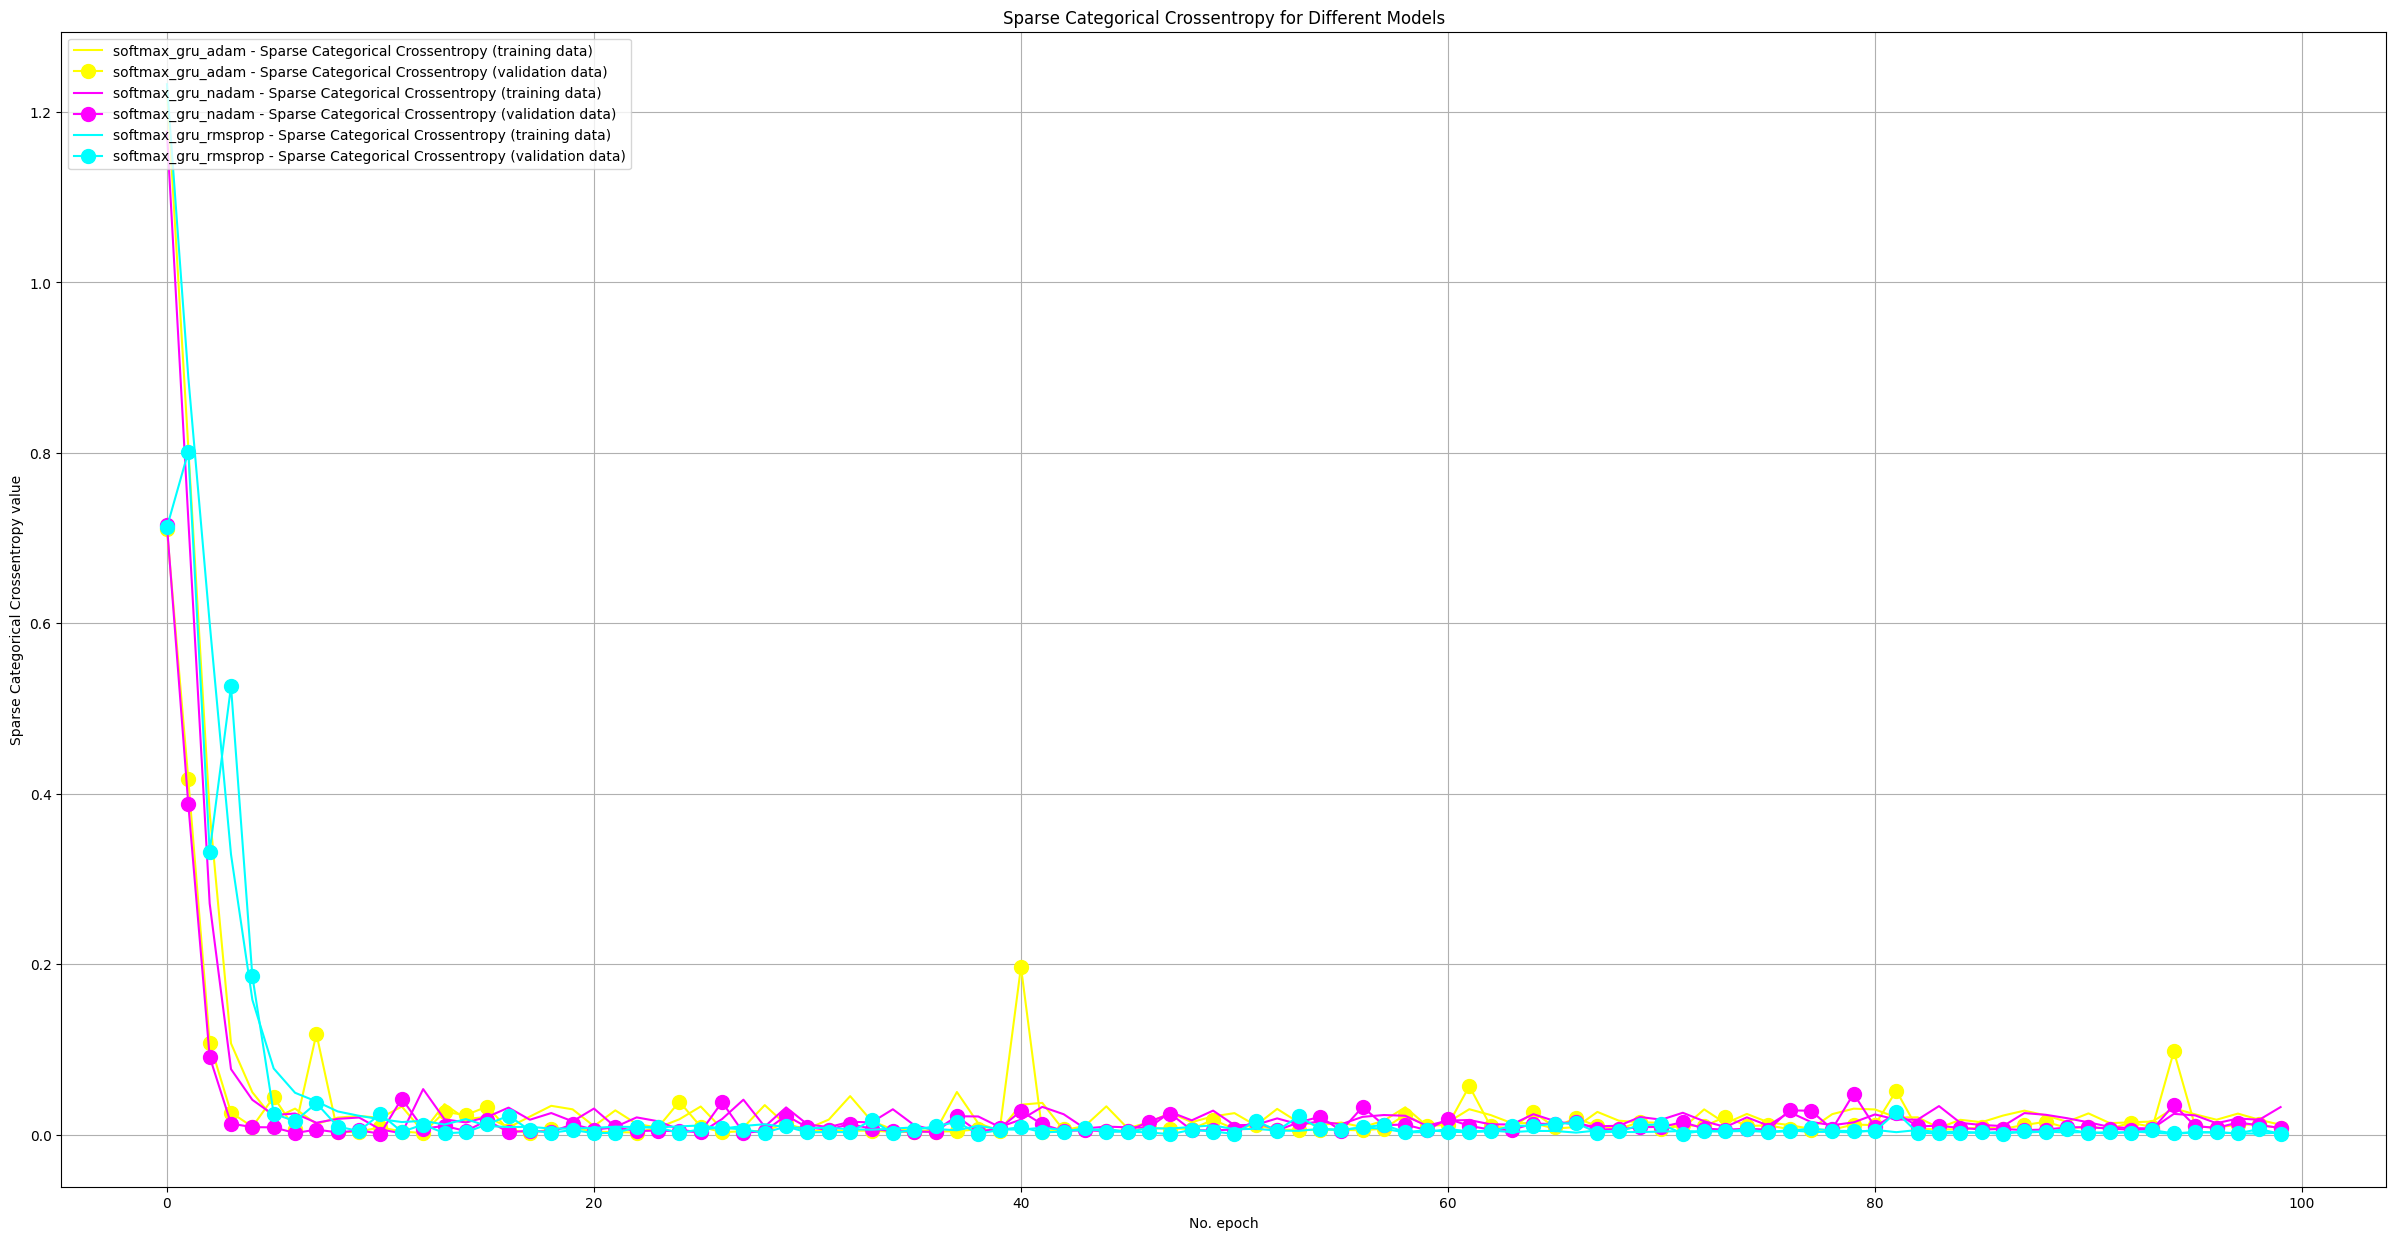

In [221]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['loss'], label=f'{model_name} - Sparse Categorical Crossentropy (training data)', color=color_plot)
    plt.plot(history.history['val_loss'], label=f'{model_name} - Sparse Categorical Crossentropy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Sparse Categorical Crossentropy for Different Models')
plt.ylabel('Sparse Categorical Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

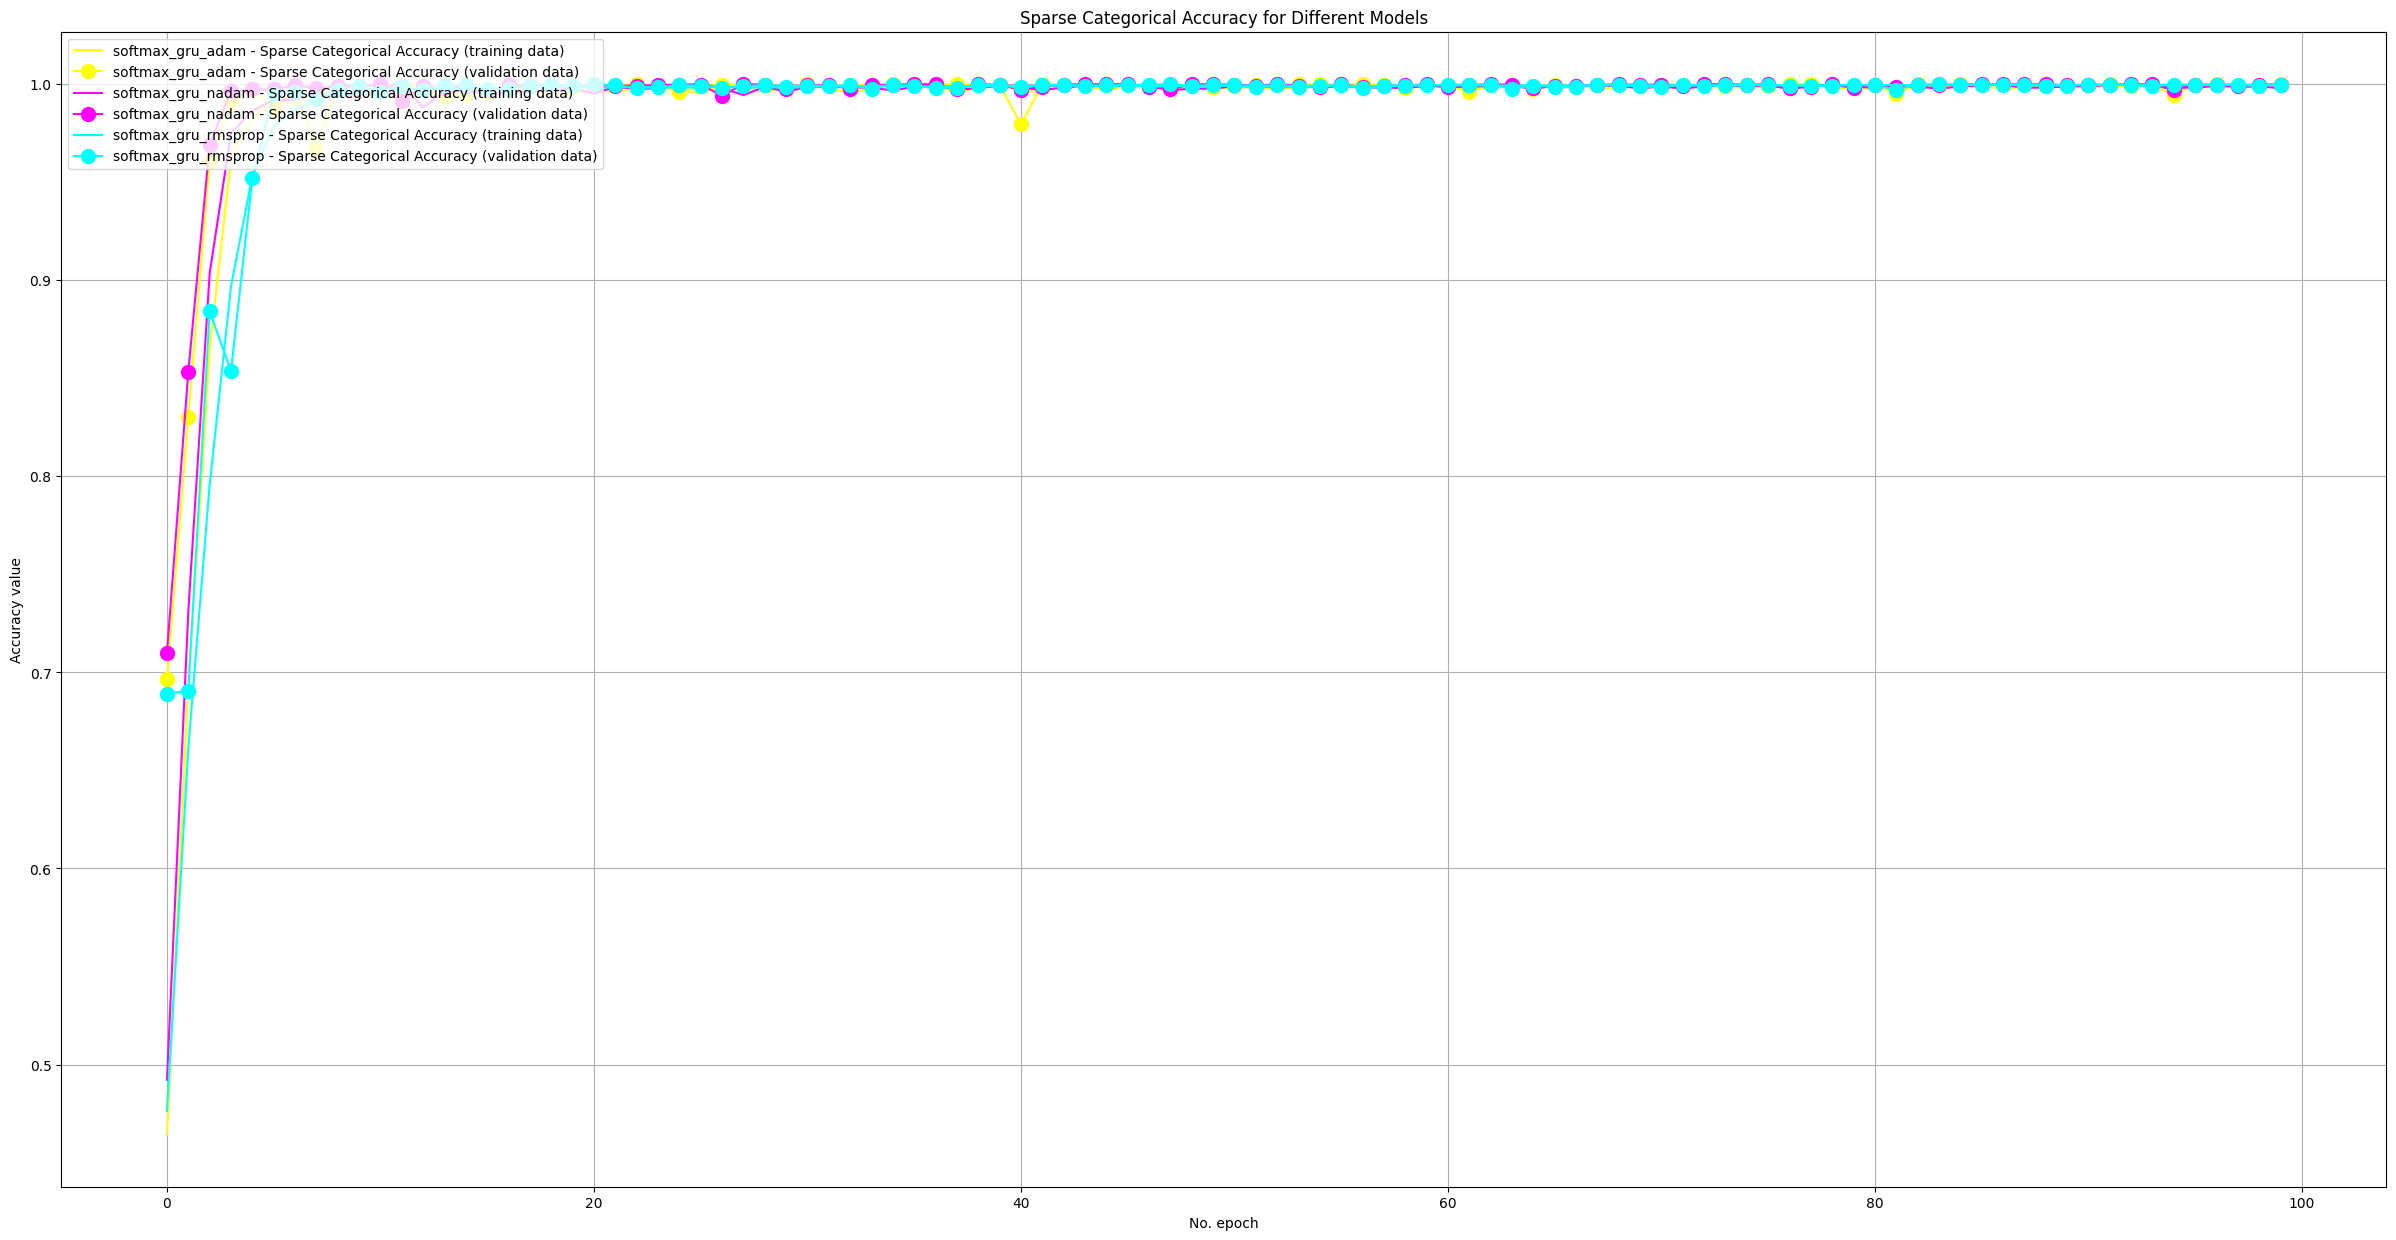

In [222]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['sparse_categorical_accuracy'], label=f'{model_name} - Sparse Categorical Accuracy (training data)', color=color_plot)
    plt.plot(history.history['val_sparse_categorical_accuracy'], label=f'{model_name} - Sparse Categorical Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Sparse Categorical Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

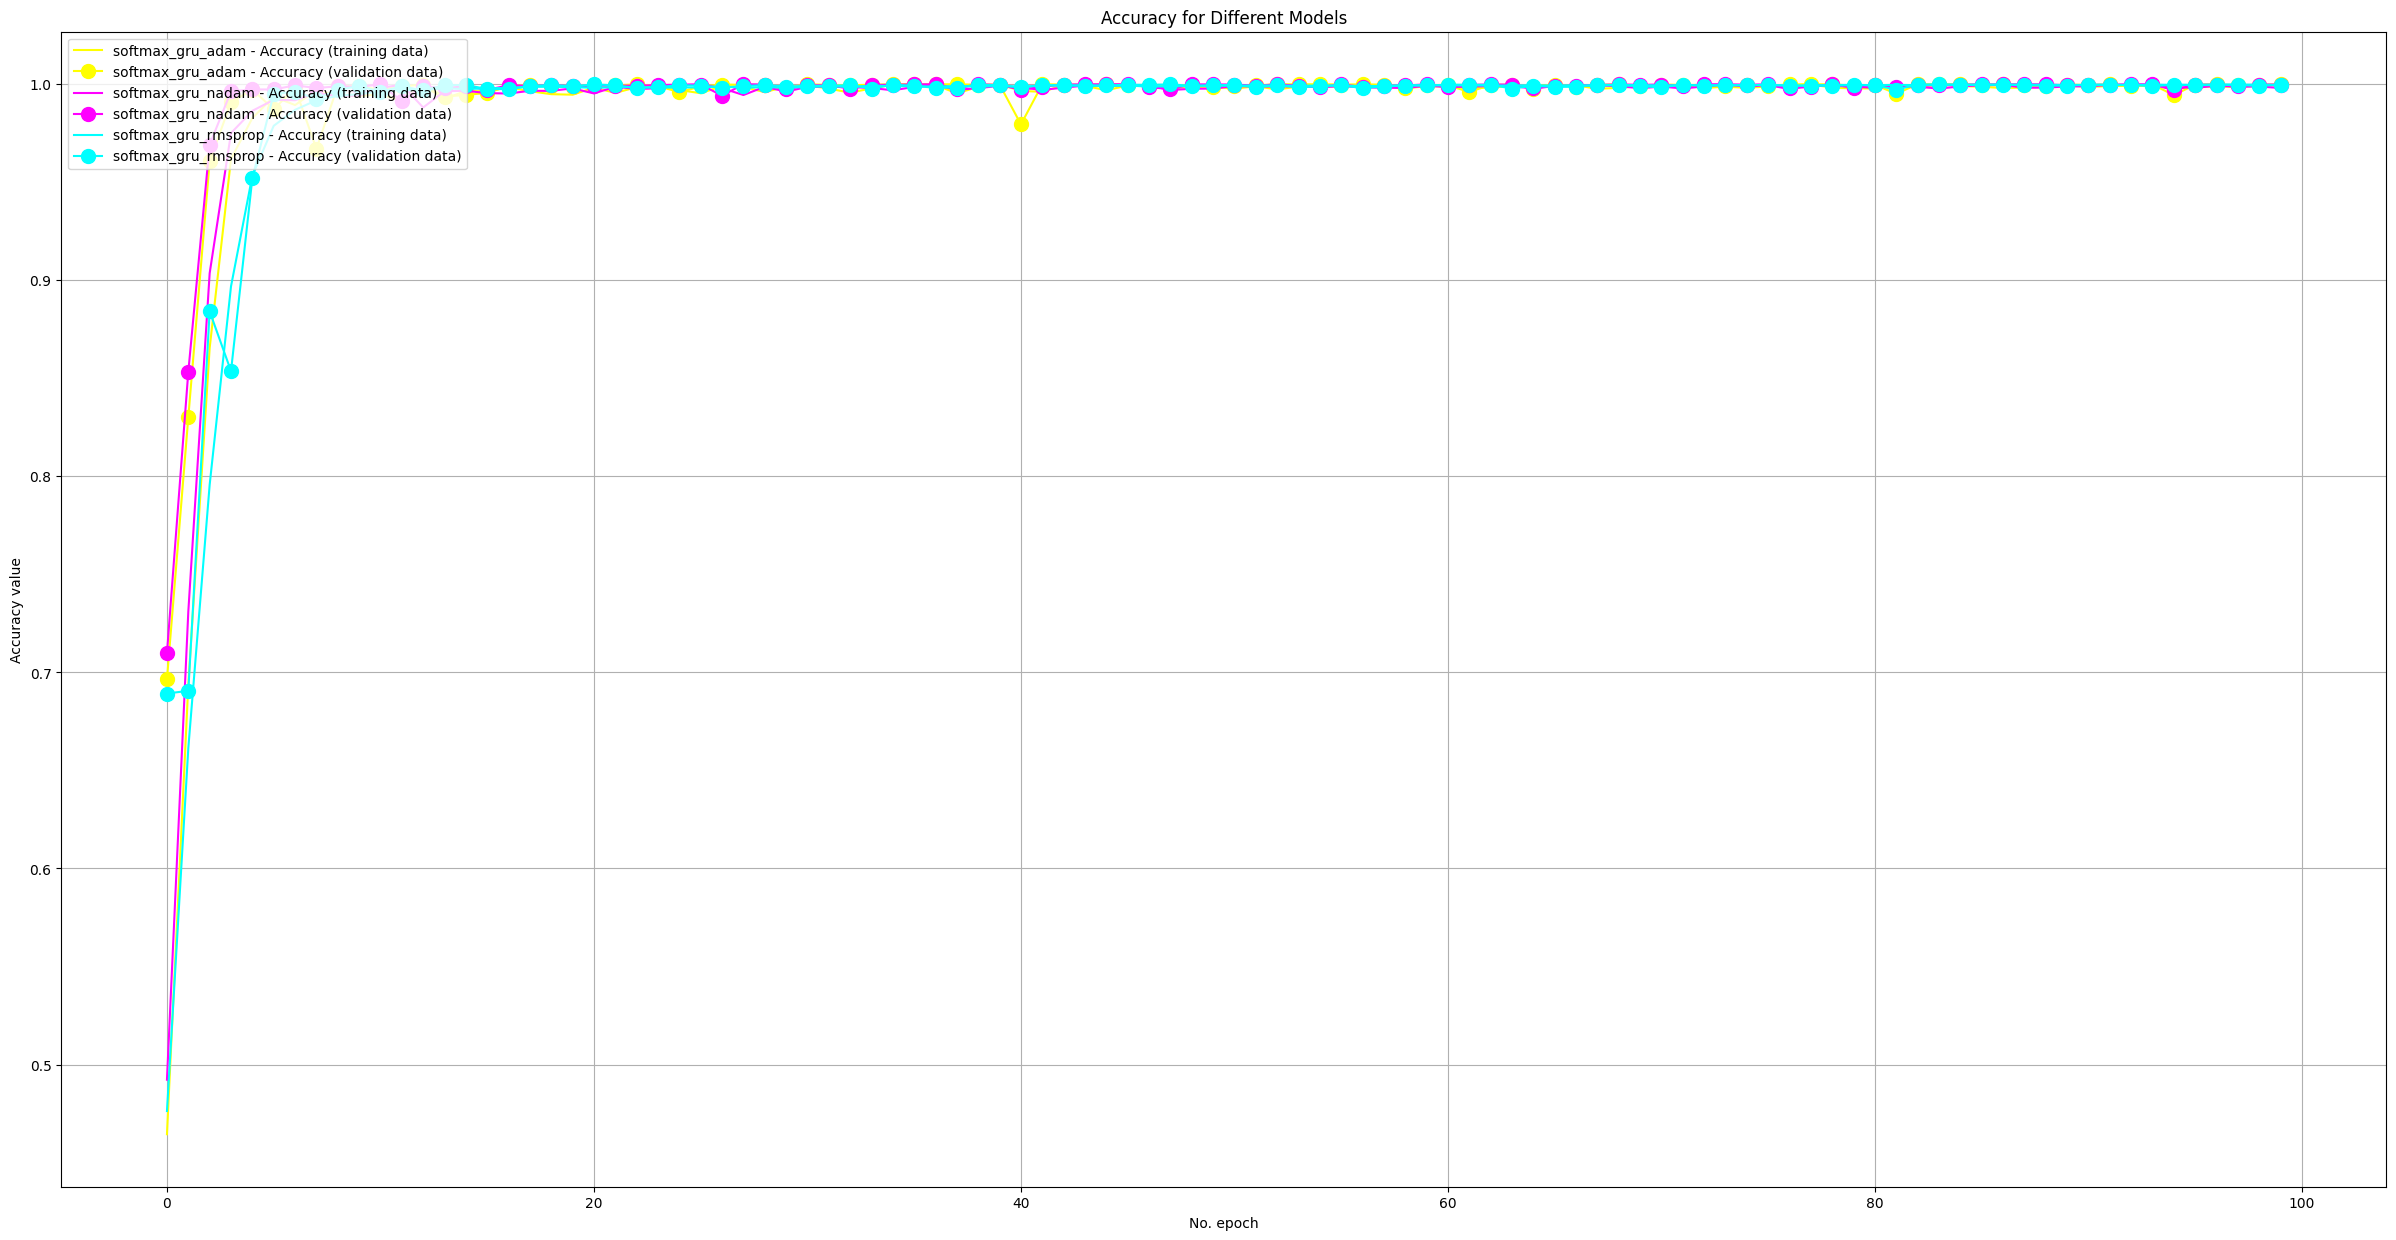

In [223]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['accuracy'], label=f'{model_name} - Accuracy (training data)', color=color_plot)
    plt.plot(history.history['val_accuracy'], label=f'{model_name} - Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# Validation Model

In [224]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef, classification_report

In [225]:
labels = [
    "Baseline",
    "Stress",
    "Amusement"
]

In [226]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

In [227]:
validation_features.shape, validation_targets.shape

((2230, 60, 5), (2230,))

ROC AUC Score for Stress Label: 0.6647213454180072 for model: softmax_gru_adam
Best Threshold=1, G-Mean=0.5899806580003087 for model: softmax_gru_adam
True Positive Rate for softmax_gru_adam: [0.         0.35849057 1.        ]


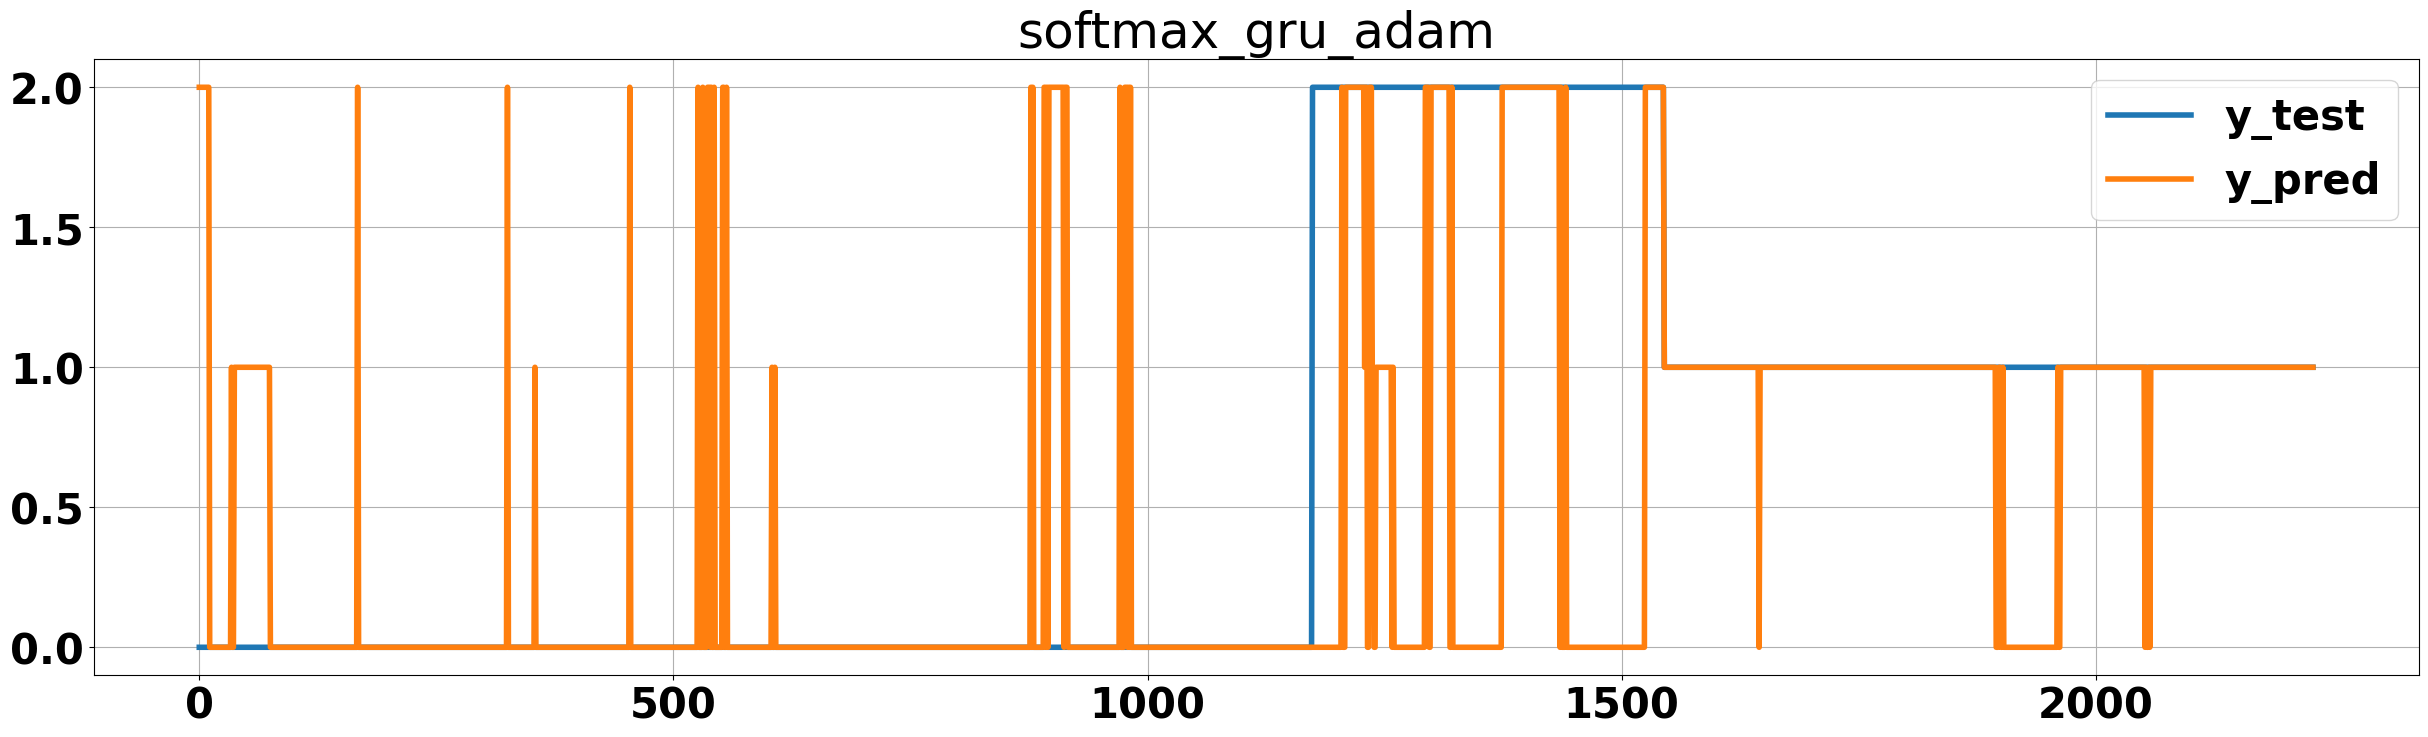

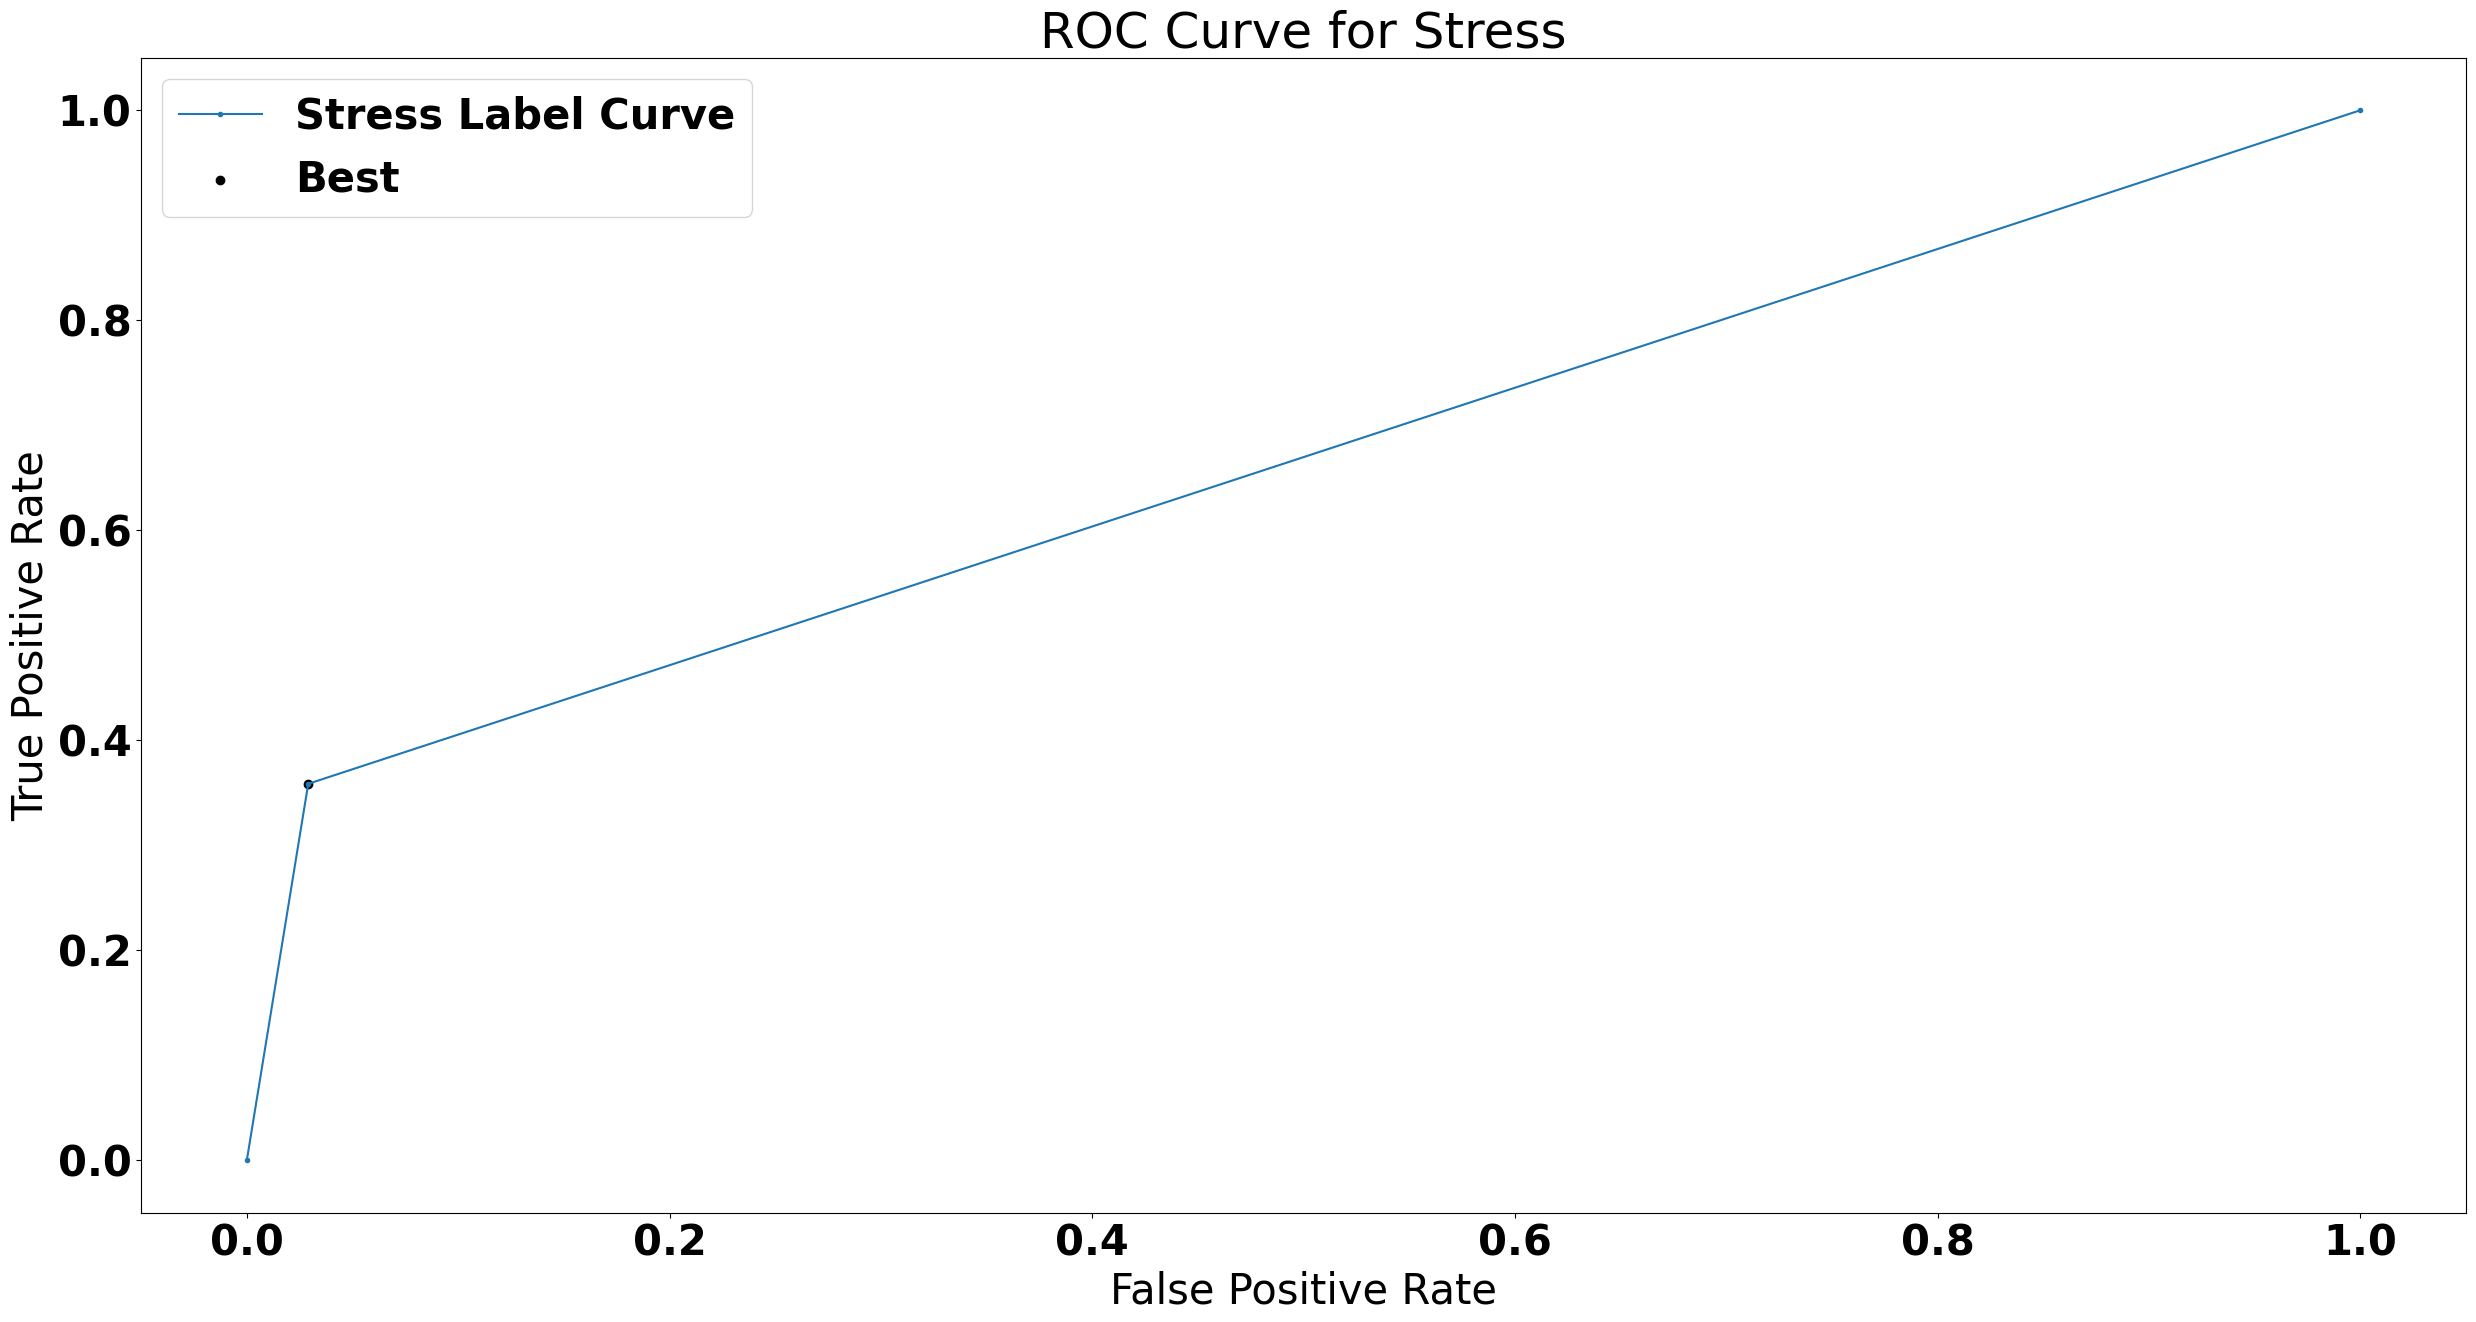

Recalls Availables for softmax_gru_adam: [1.         0.35849057 0.        ]


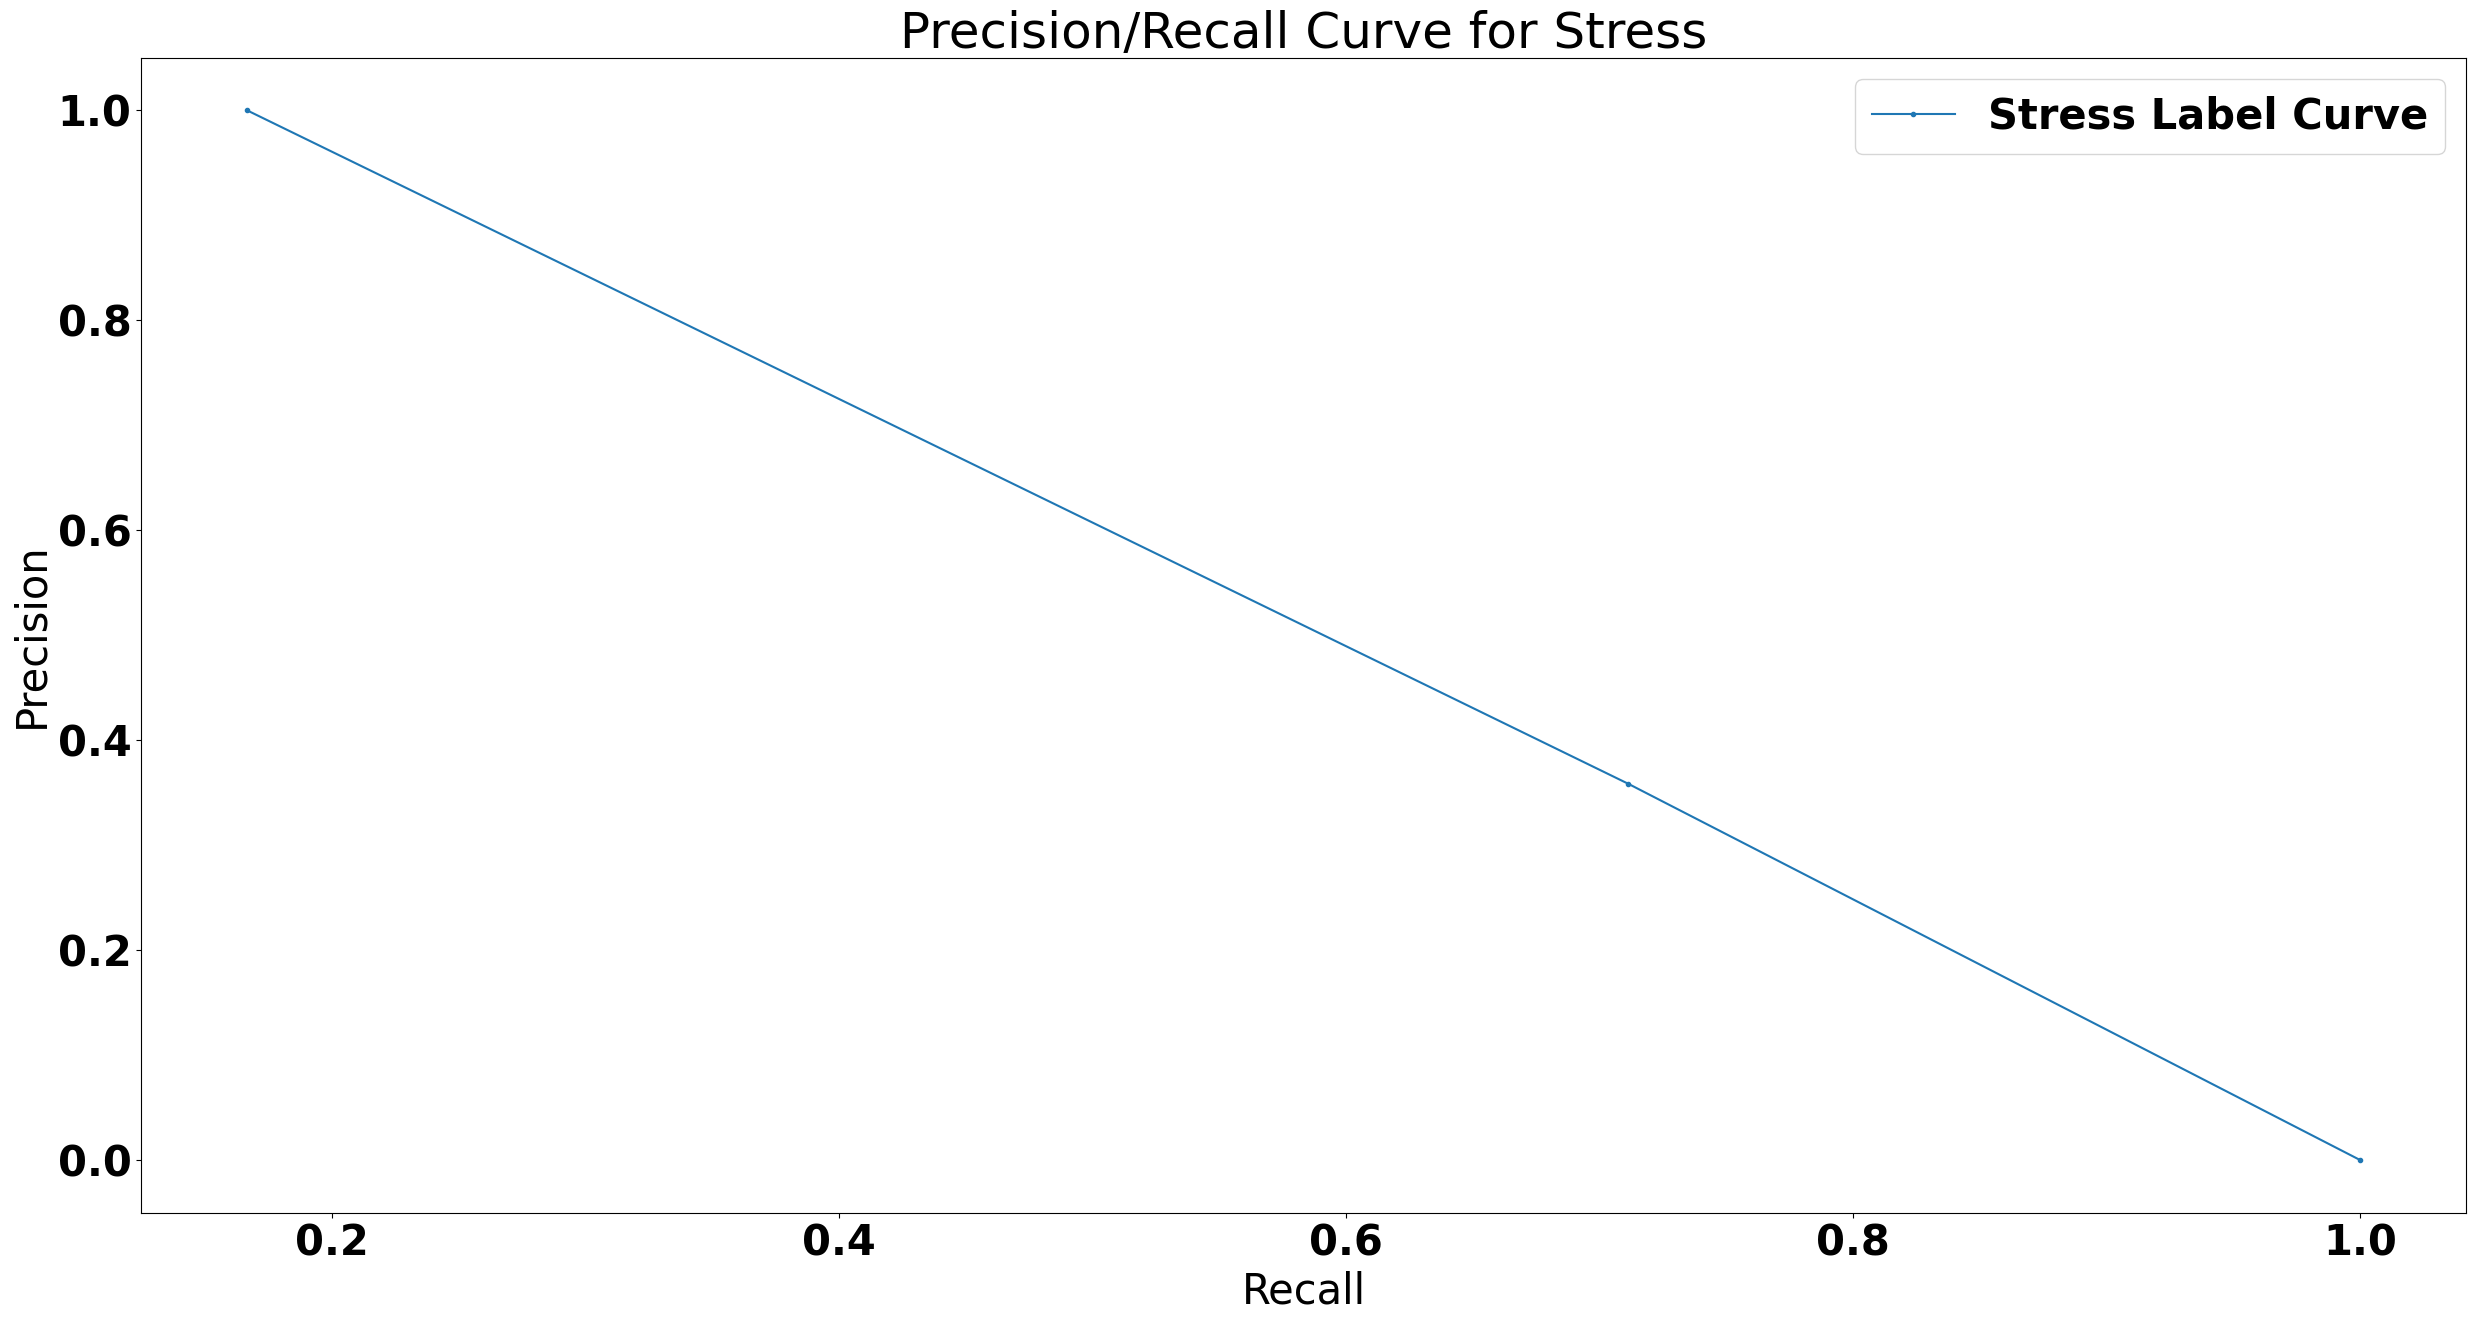

[[1078   42   54]
 [  69  616    0]
 [ 216   22  133]]
           Baseline  Stress  Amusement
Baseline       1078      42         54
Stress           69     616          0
Amusement       216      22        133


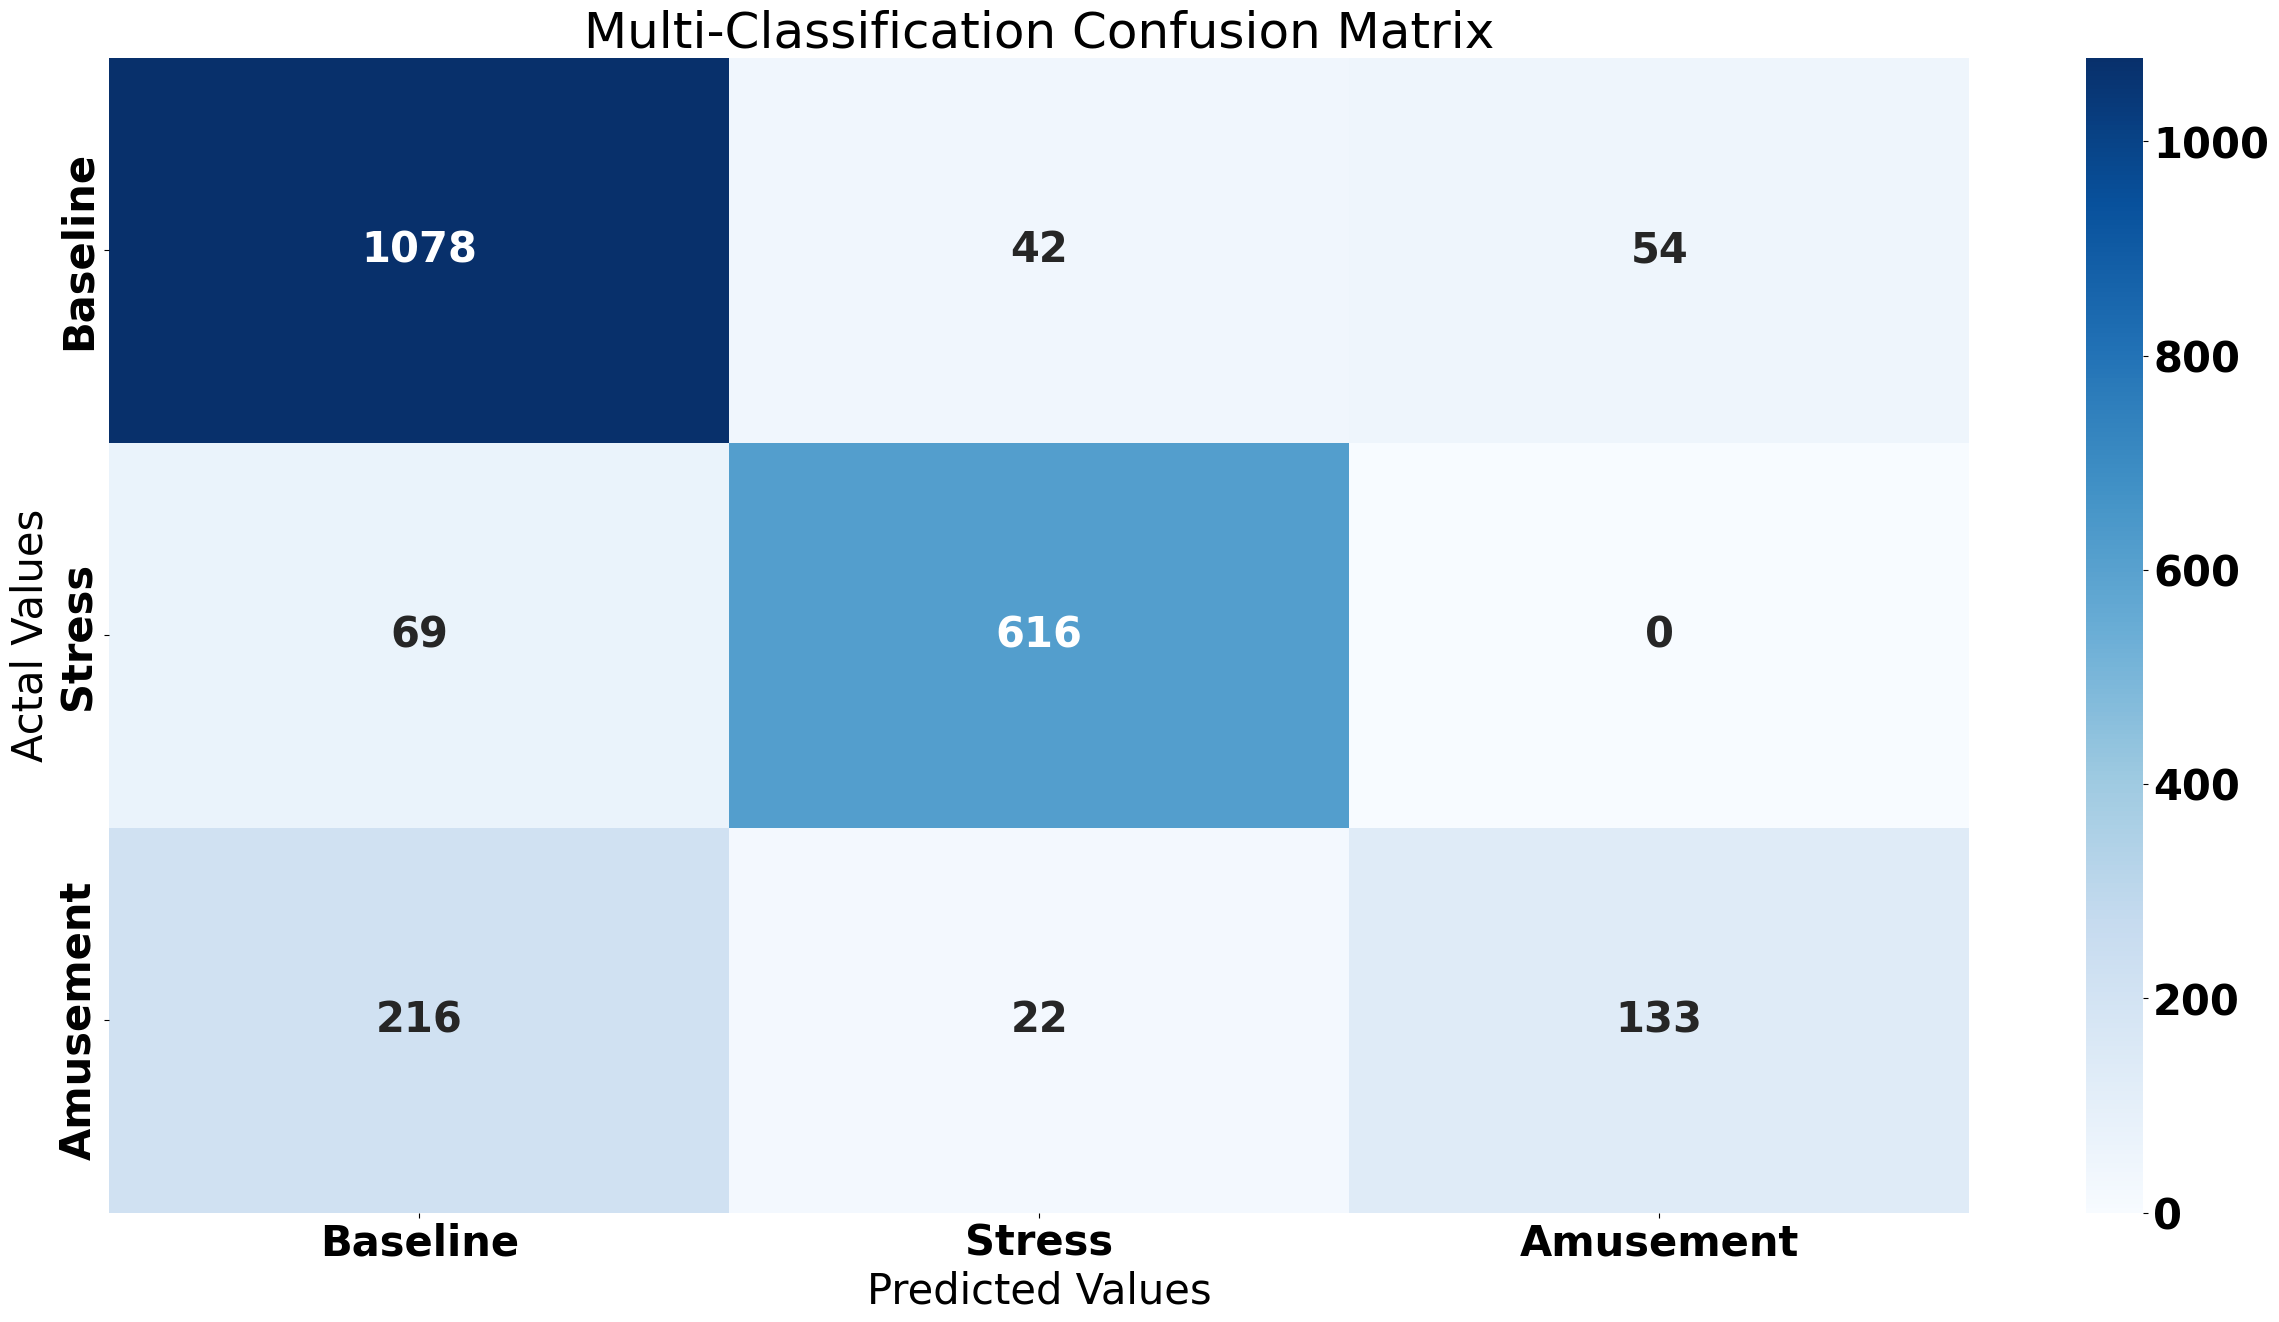

[0 1 2] [1174  685  371]
[0 1 2] [0.5264574  0.30717489 0.16636771]
[0 1 2] [1363  680  187]
[0 1 2] [0.61121076 0.30493274 0.0838565 ]
Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.79      0.92      0.85      1174
      Stress       0.91      0.90      0.90       685
   Amusement       0.71      0.36      0.48       371

    accuracy                           0.82      2230
   macro avg       0.80      0.73      0.74      2230
weighted avg       0.81      0.82      0.80      2230

Matthews Correlation: 0.6932839184894407
ROC AUC Score for Stress Label: 0.7049387477544227 for model: softmax_gru_nadam
Best Threshold=1, G-Mean=0.6715526630762967 for model: softmax_gru_nadam
True Positive Rate for softmax_gru_nadam: [0.         0.49056604 1.        ]


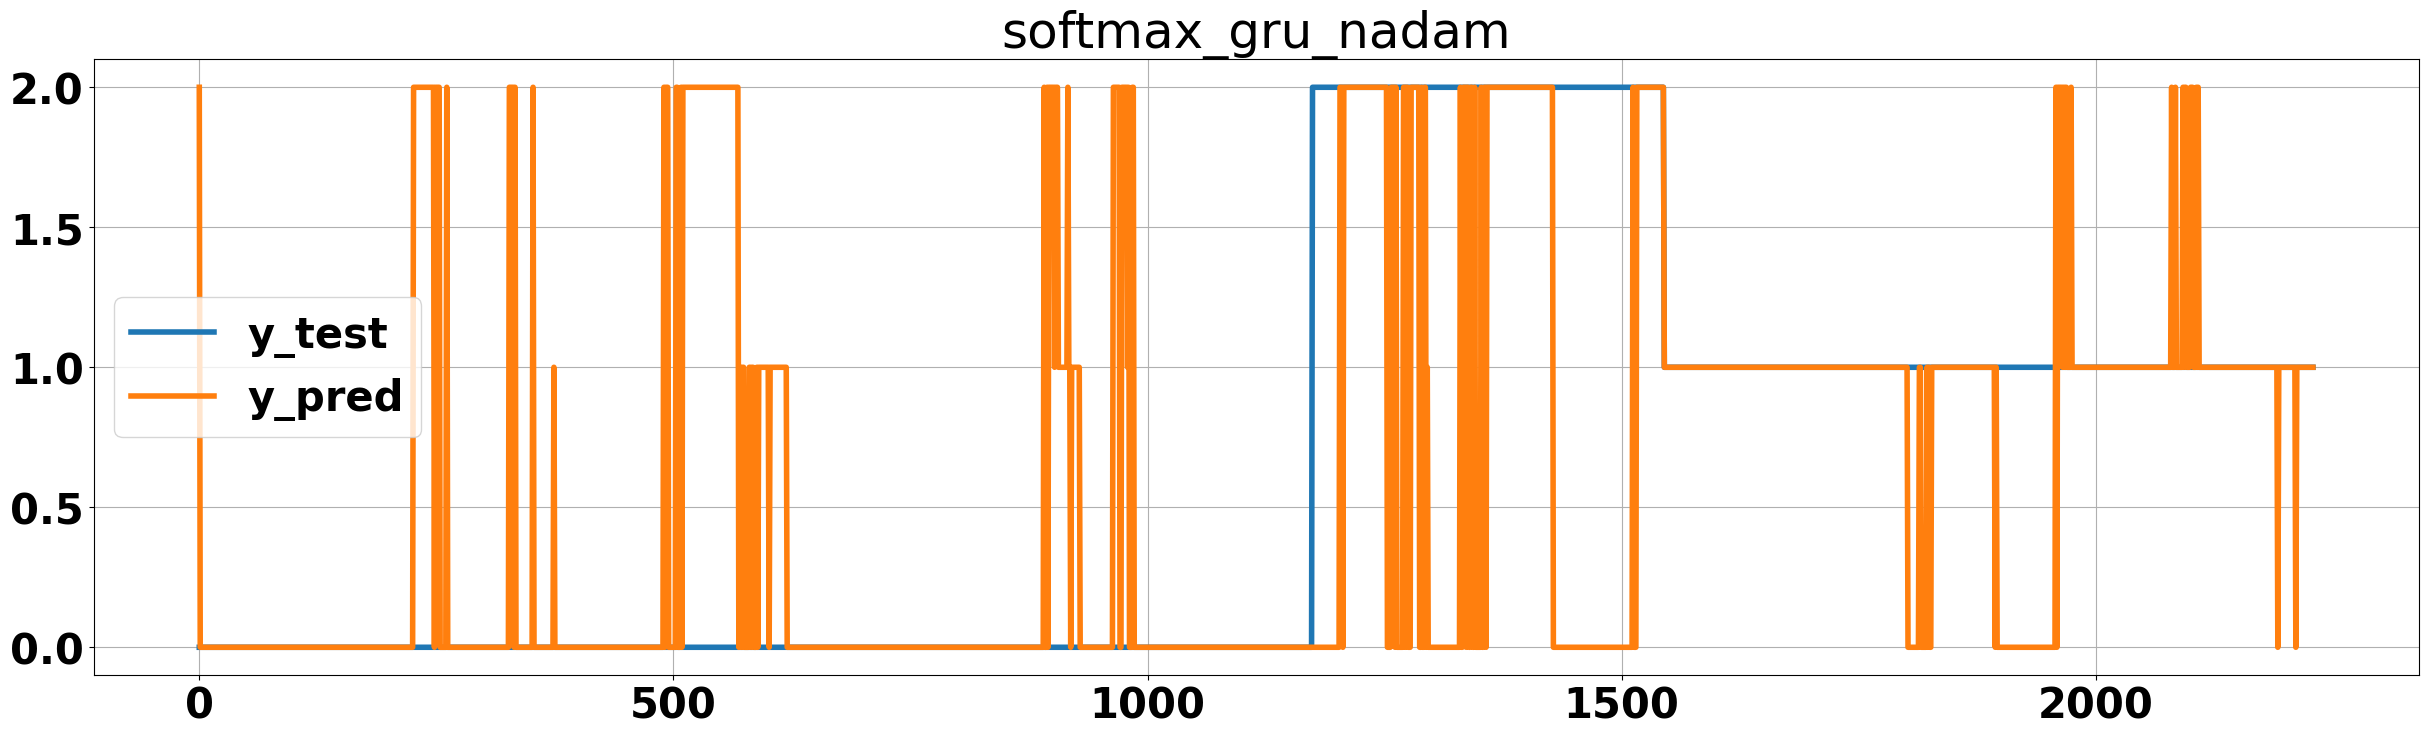

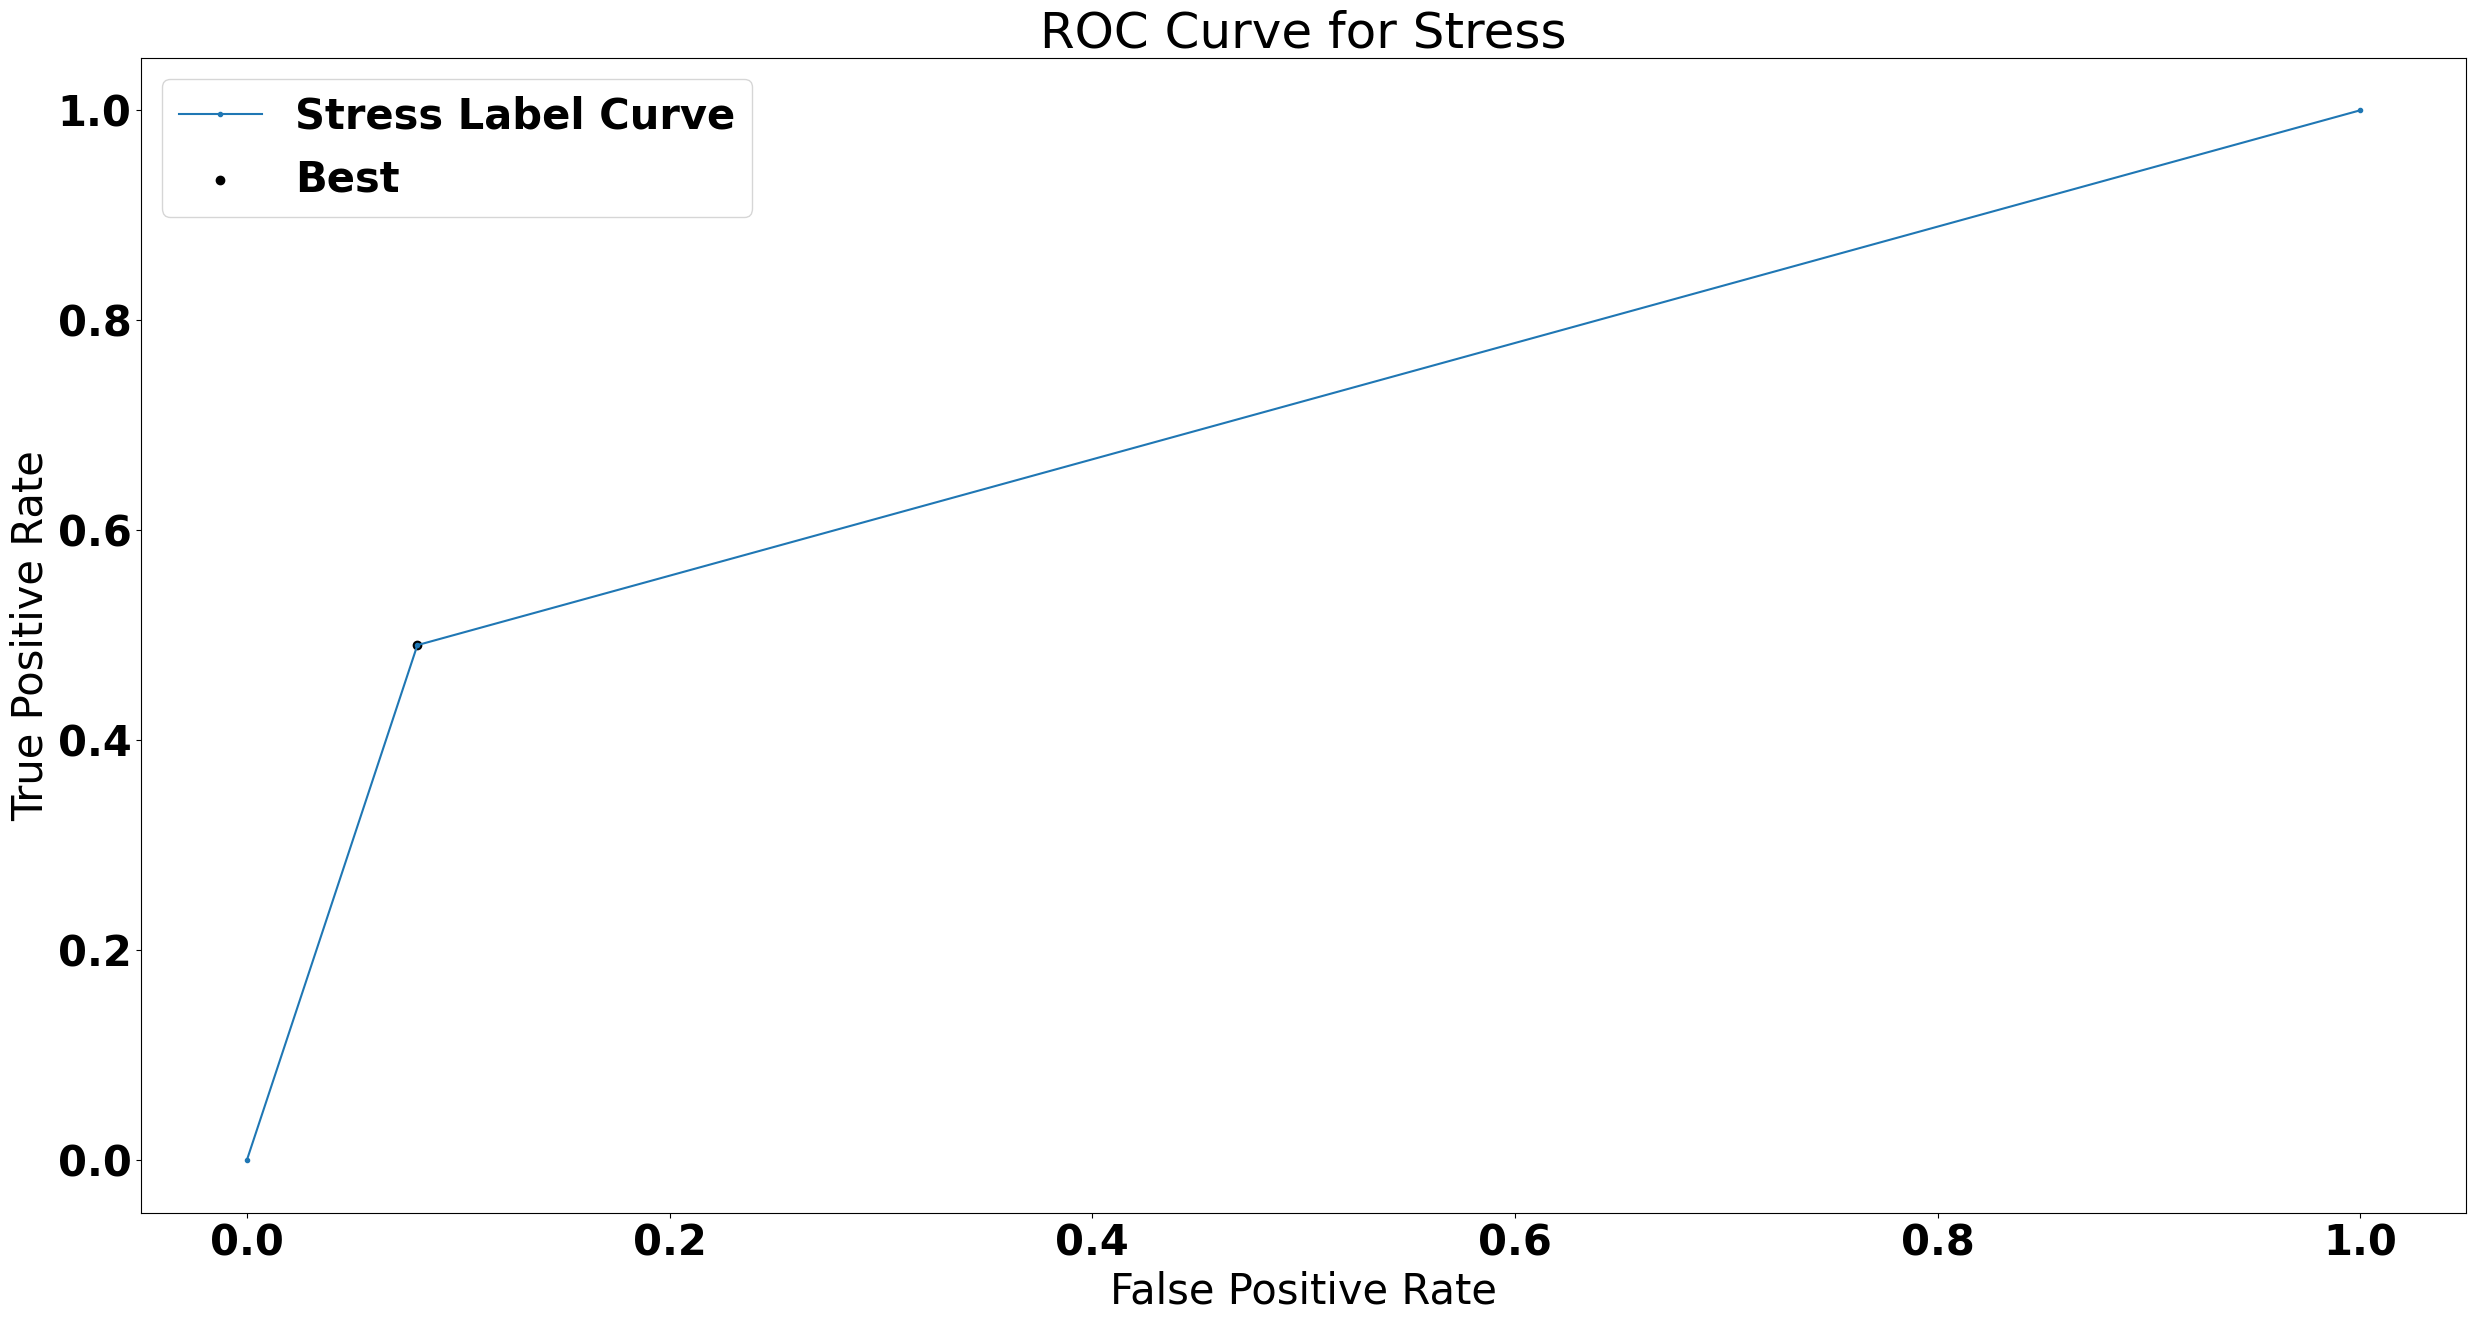

Recalls Availables for softmax_gru_nadam: [1.         0.49056604 0.        ]


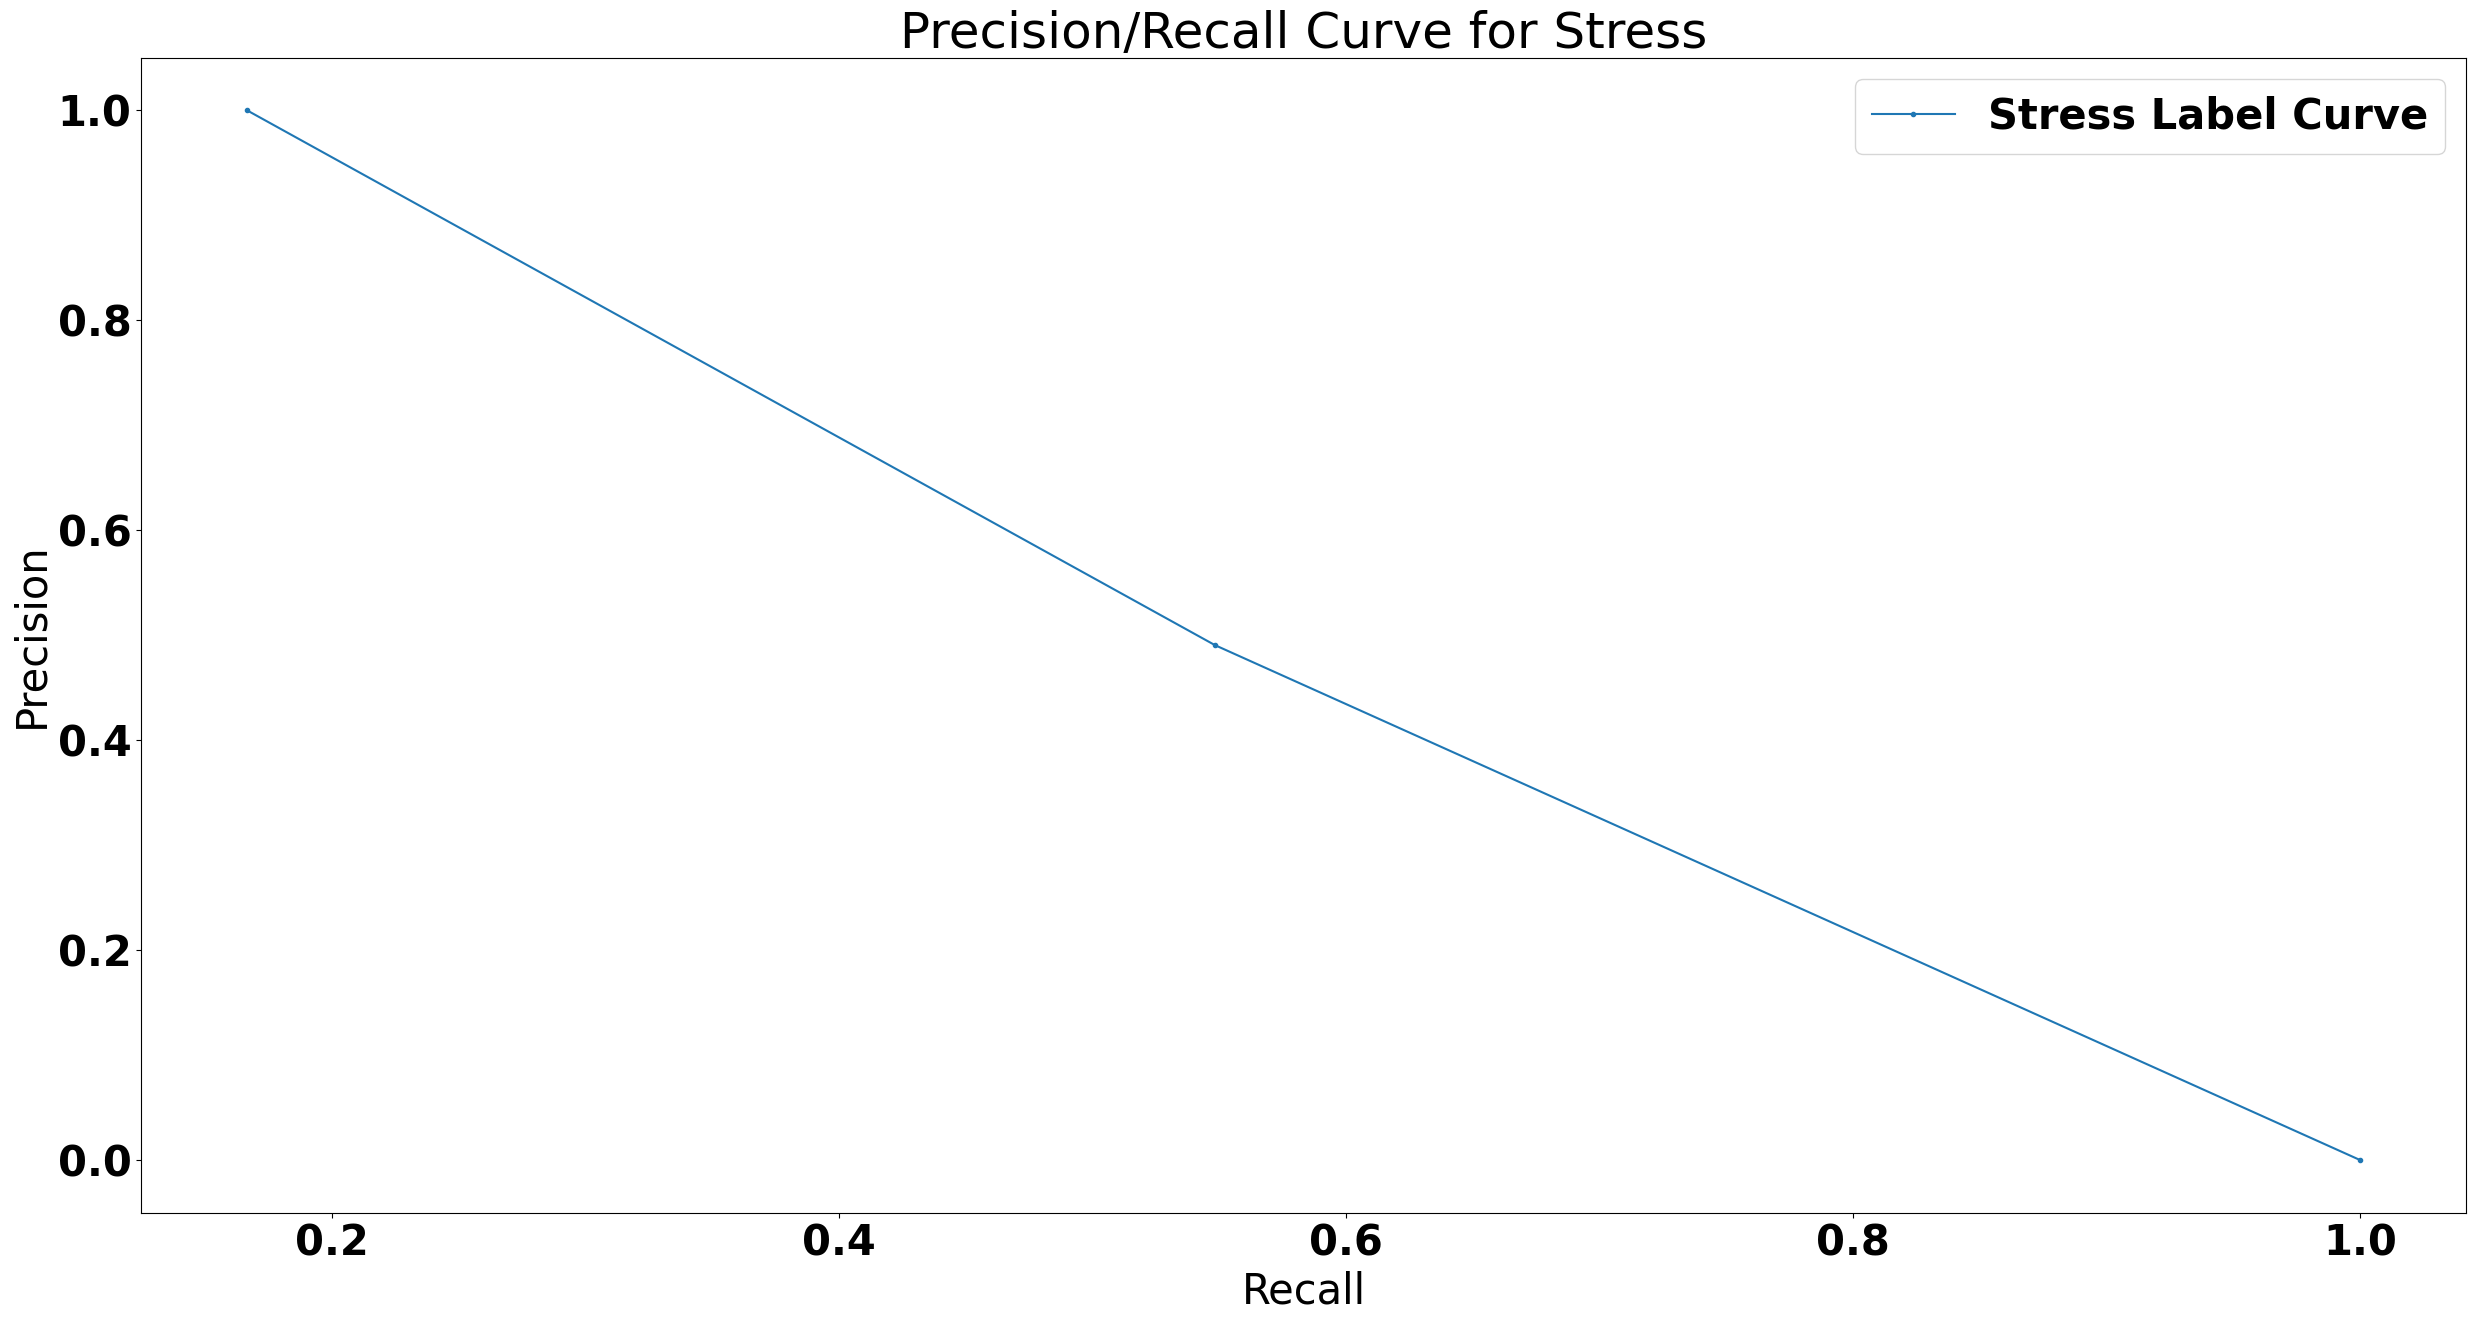

[[982  62 130]
 [ 87 578  20]
 [188   1 182]]
           Baseline  Stress  Amusement
Baseline        982      62        130
Stress           87     578         20
Amusement       188       1        182


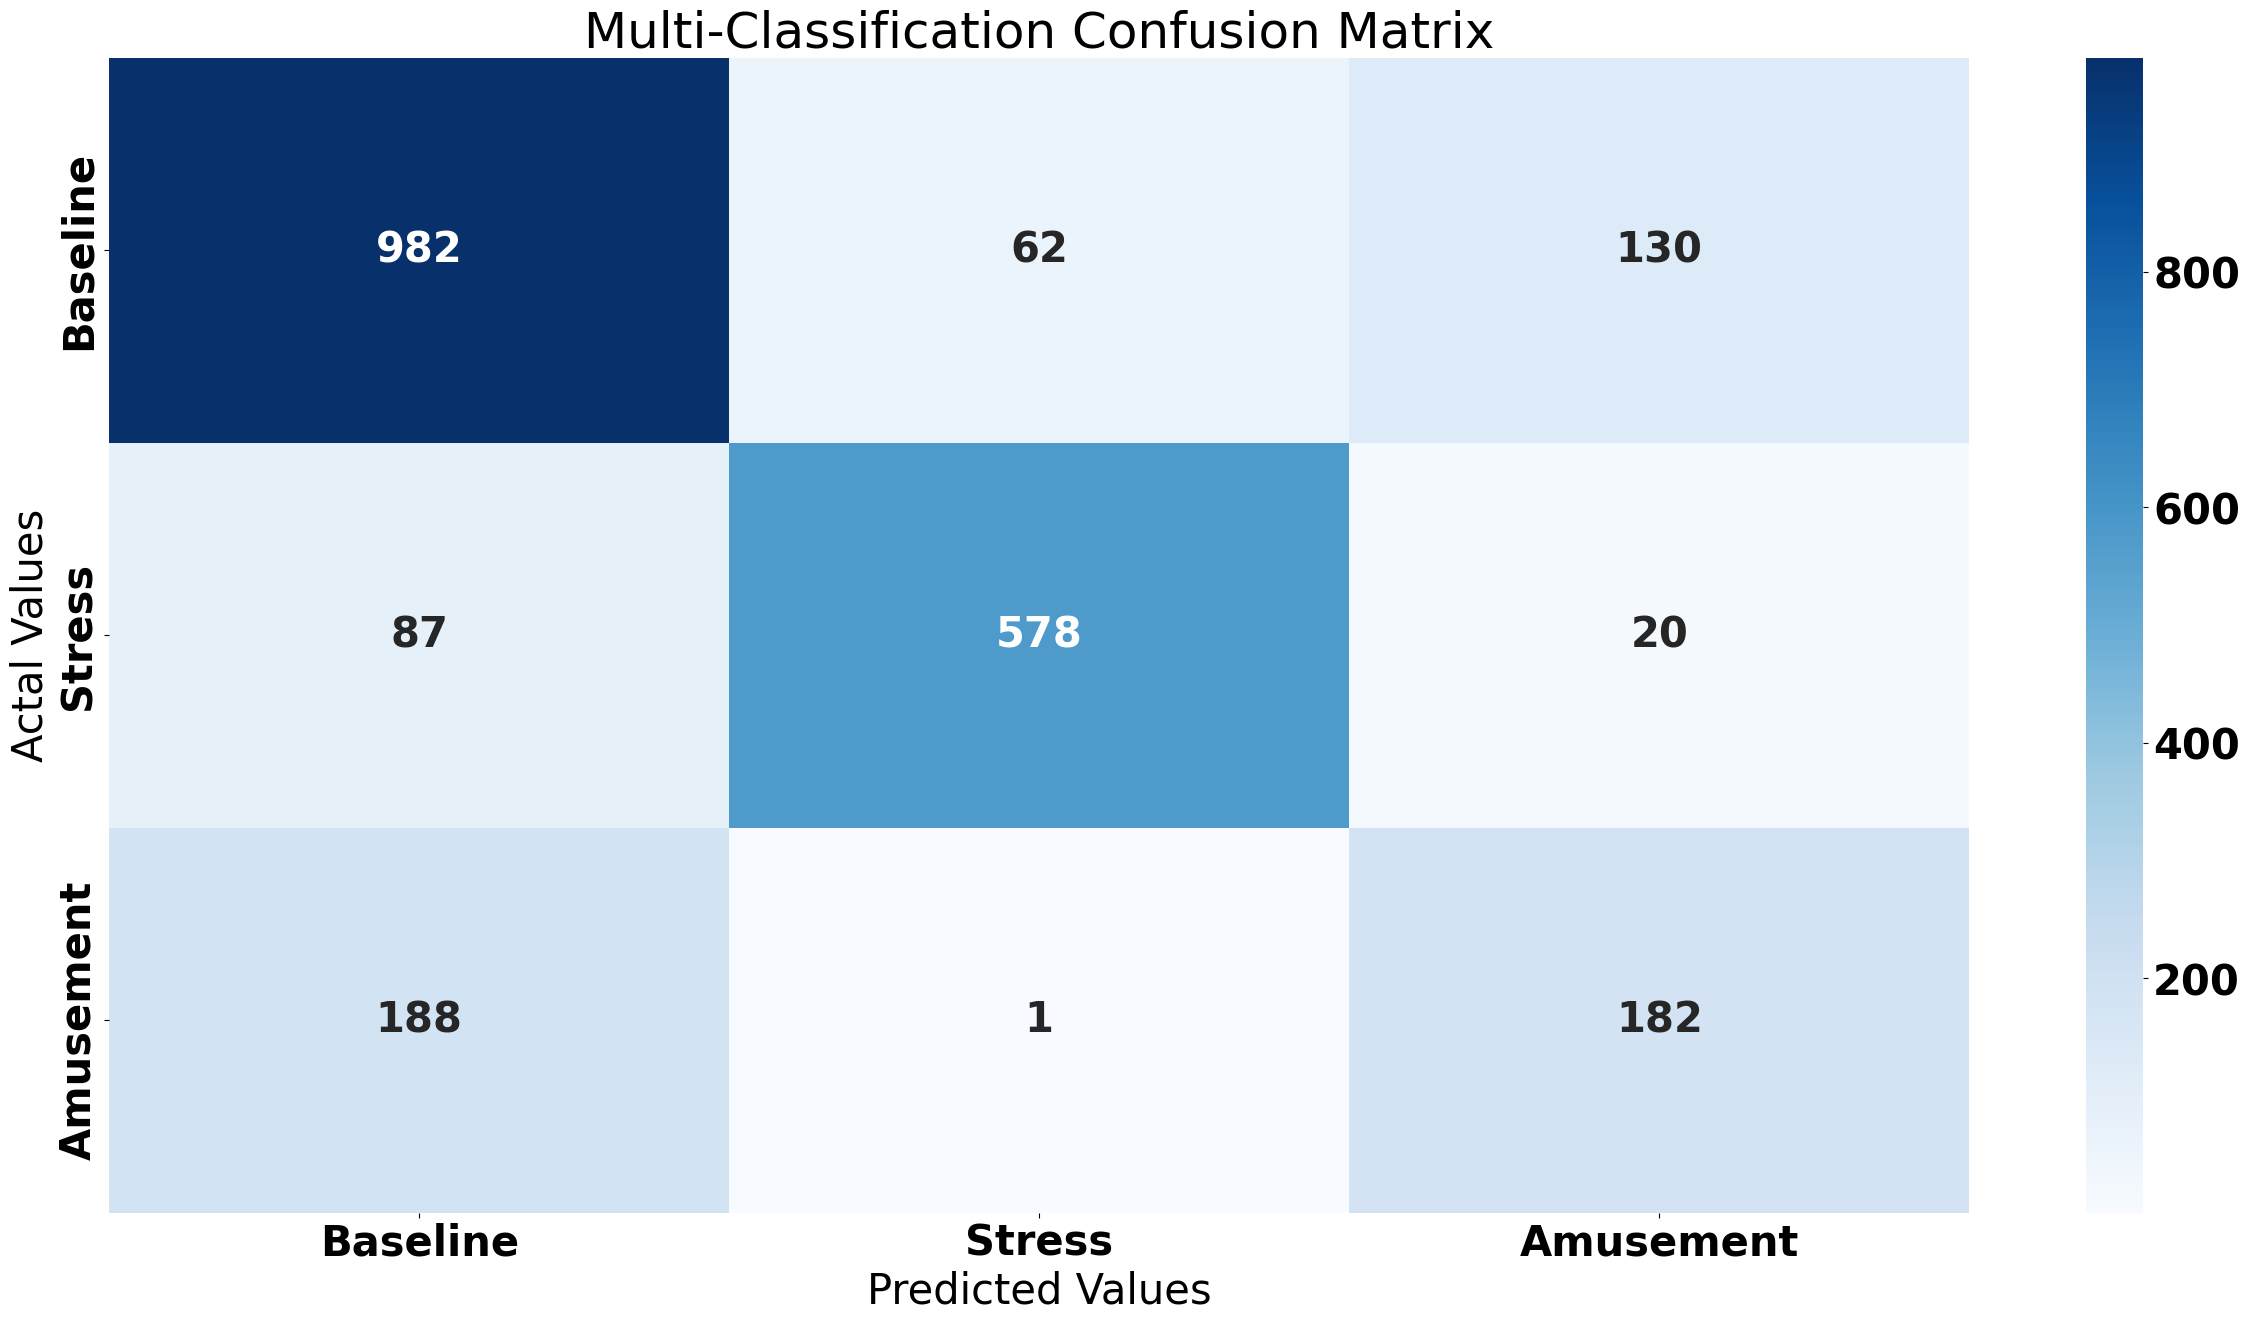

[0 1 2] [1174  685  371]
[0 1 2] [0.5264574  0.30717489 0.16636771]
[0 1 2] [1257  641  332]
[0 1 2] [0.56367713 0.28744395 0.14887892]
Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.78      0.84      0.81      1174
      Stress       0.90      0.84      0.87       685
   Amusement       0.55      0.49      0.52       371

    accuracy                           0.78      2230
   macro avg       0.74      0.72      0.73      2230
weighted avg       0.78      0.78      0.78      2230

Matthews Correlation: 0.6304448482610806
ROC AUC Score for Stress Label: 0.6035510208224286 for model: softmax_gru_rmsprop
Best Threshold=1, G-Mean=0.4896442996573674 for model: softmax_gru_rmsprop
True Positive Rate for softmax_gru_rmsprop: [0.         0.25067385 1.        ]


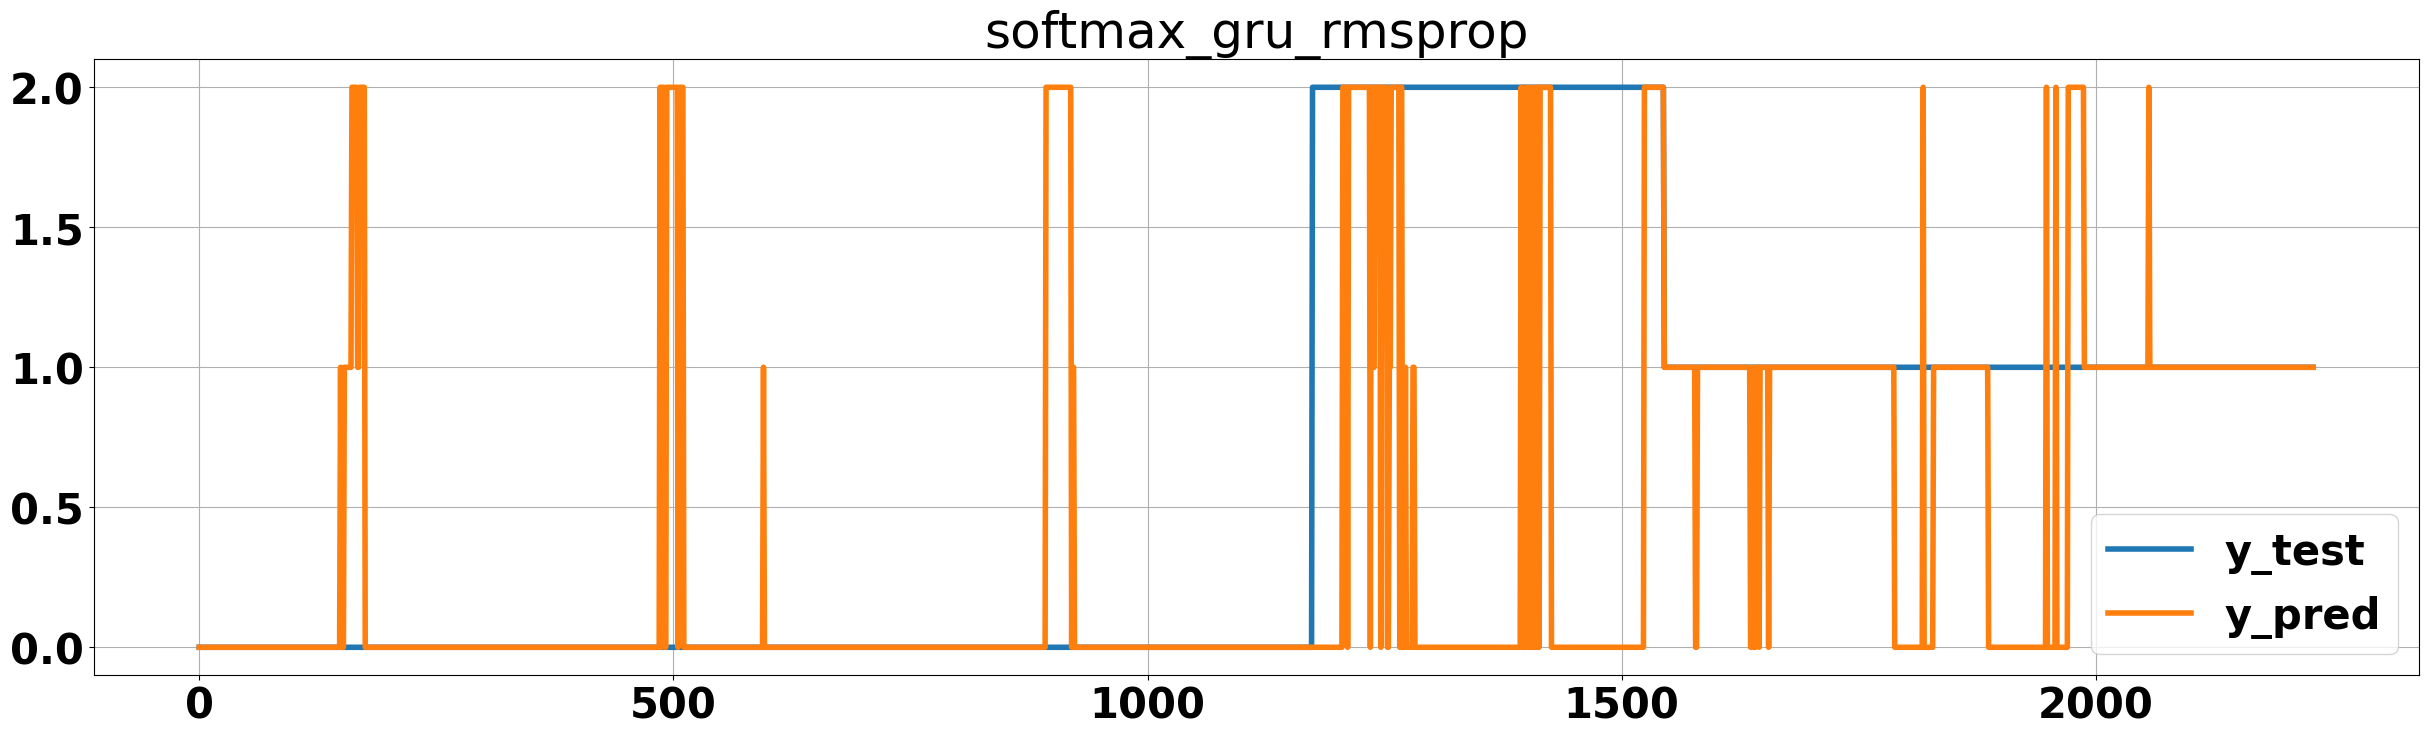

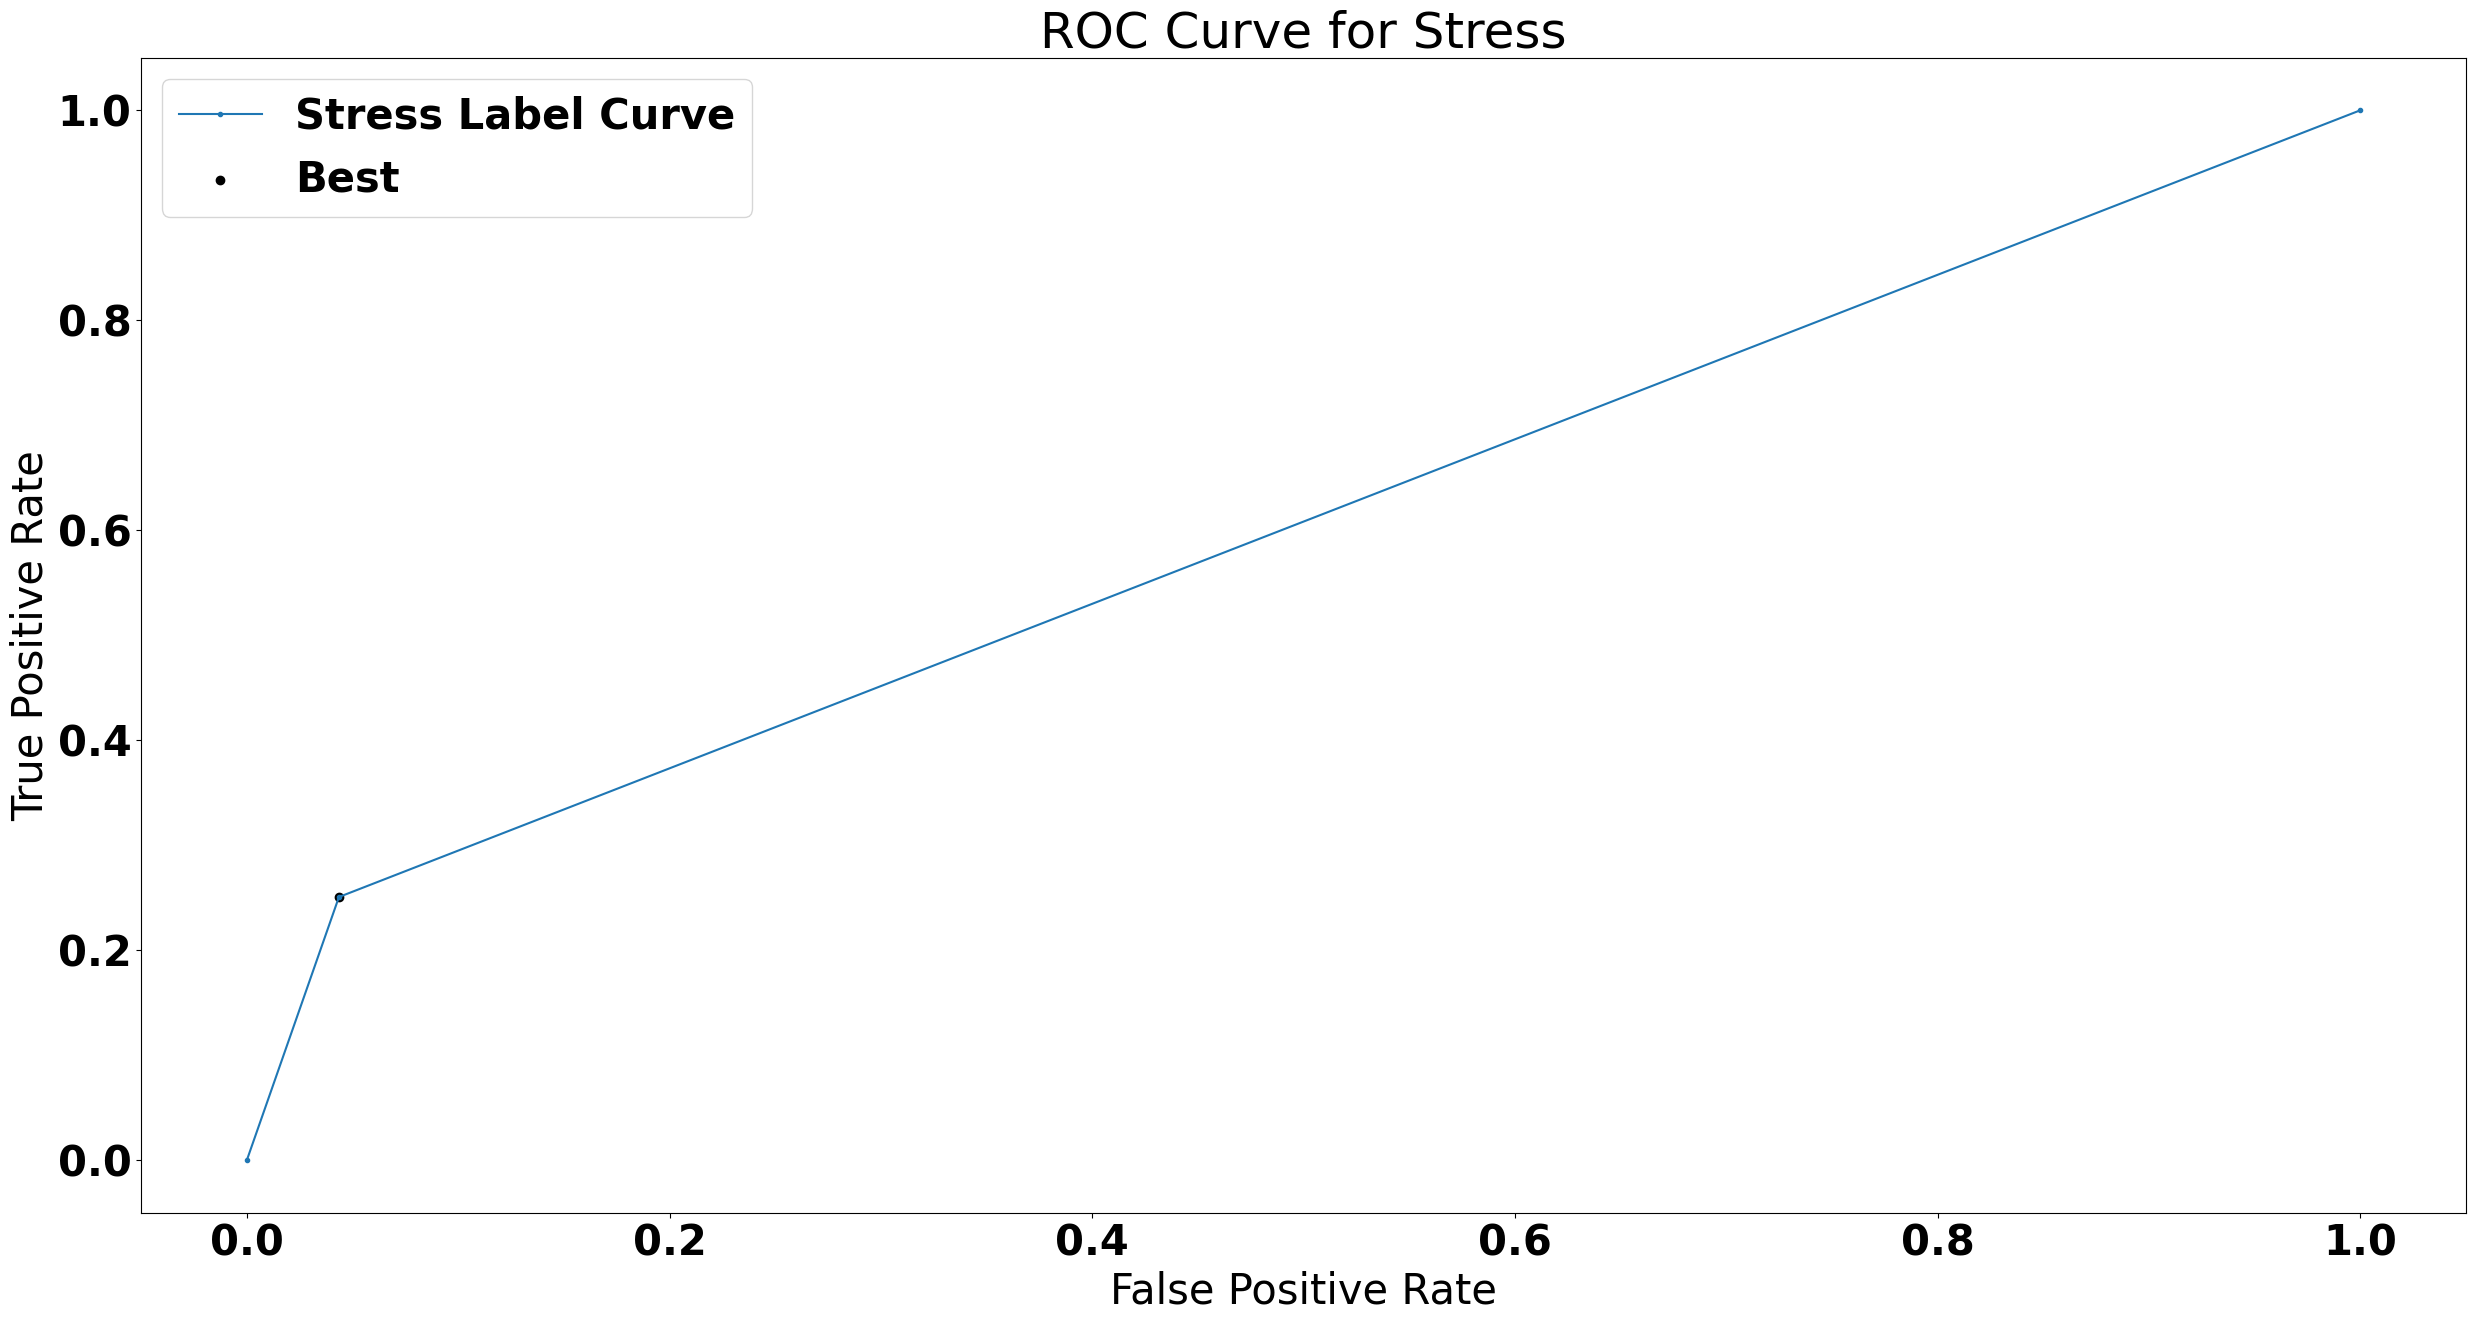

Recalls Availables for softmax_gru_rmsprop: [1.         0.25067385 0.        ]


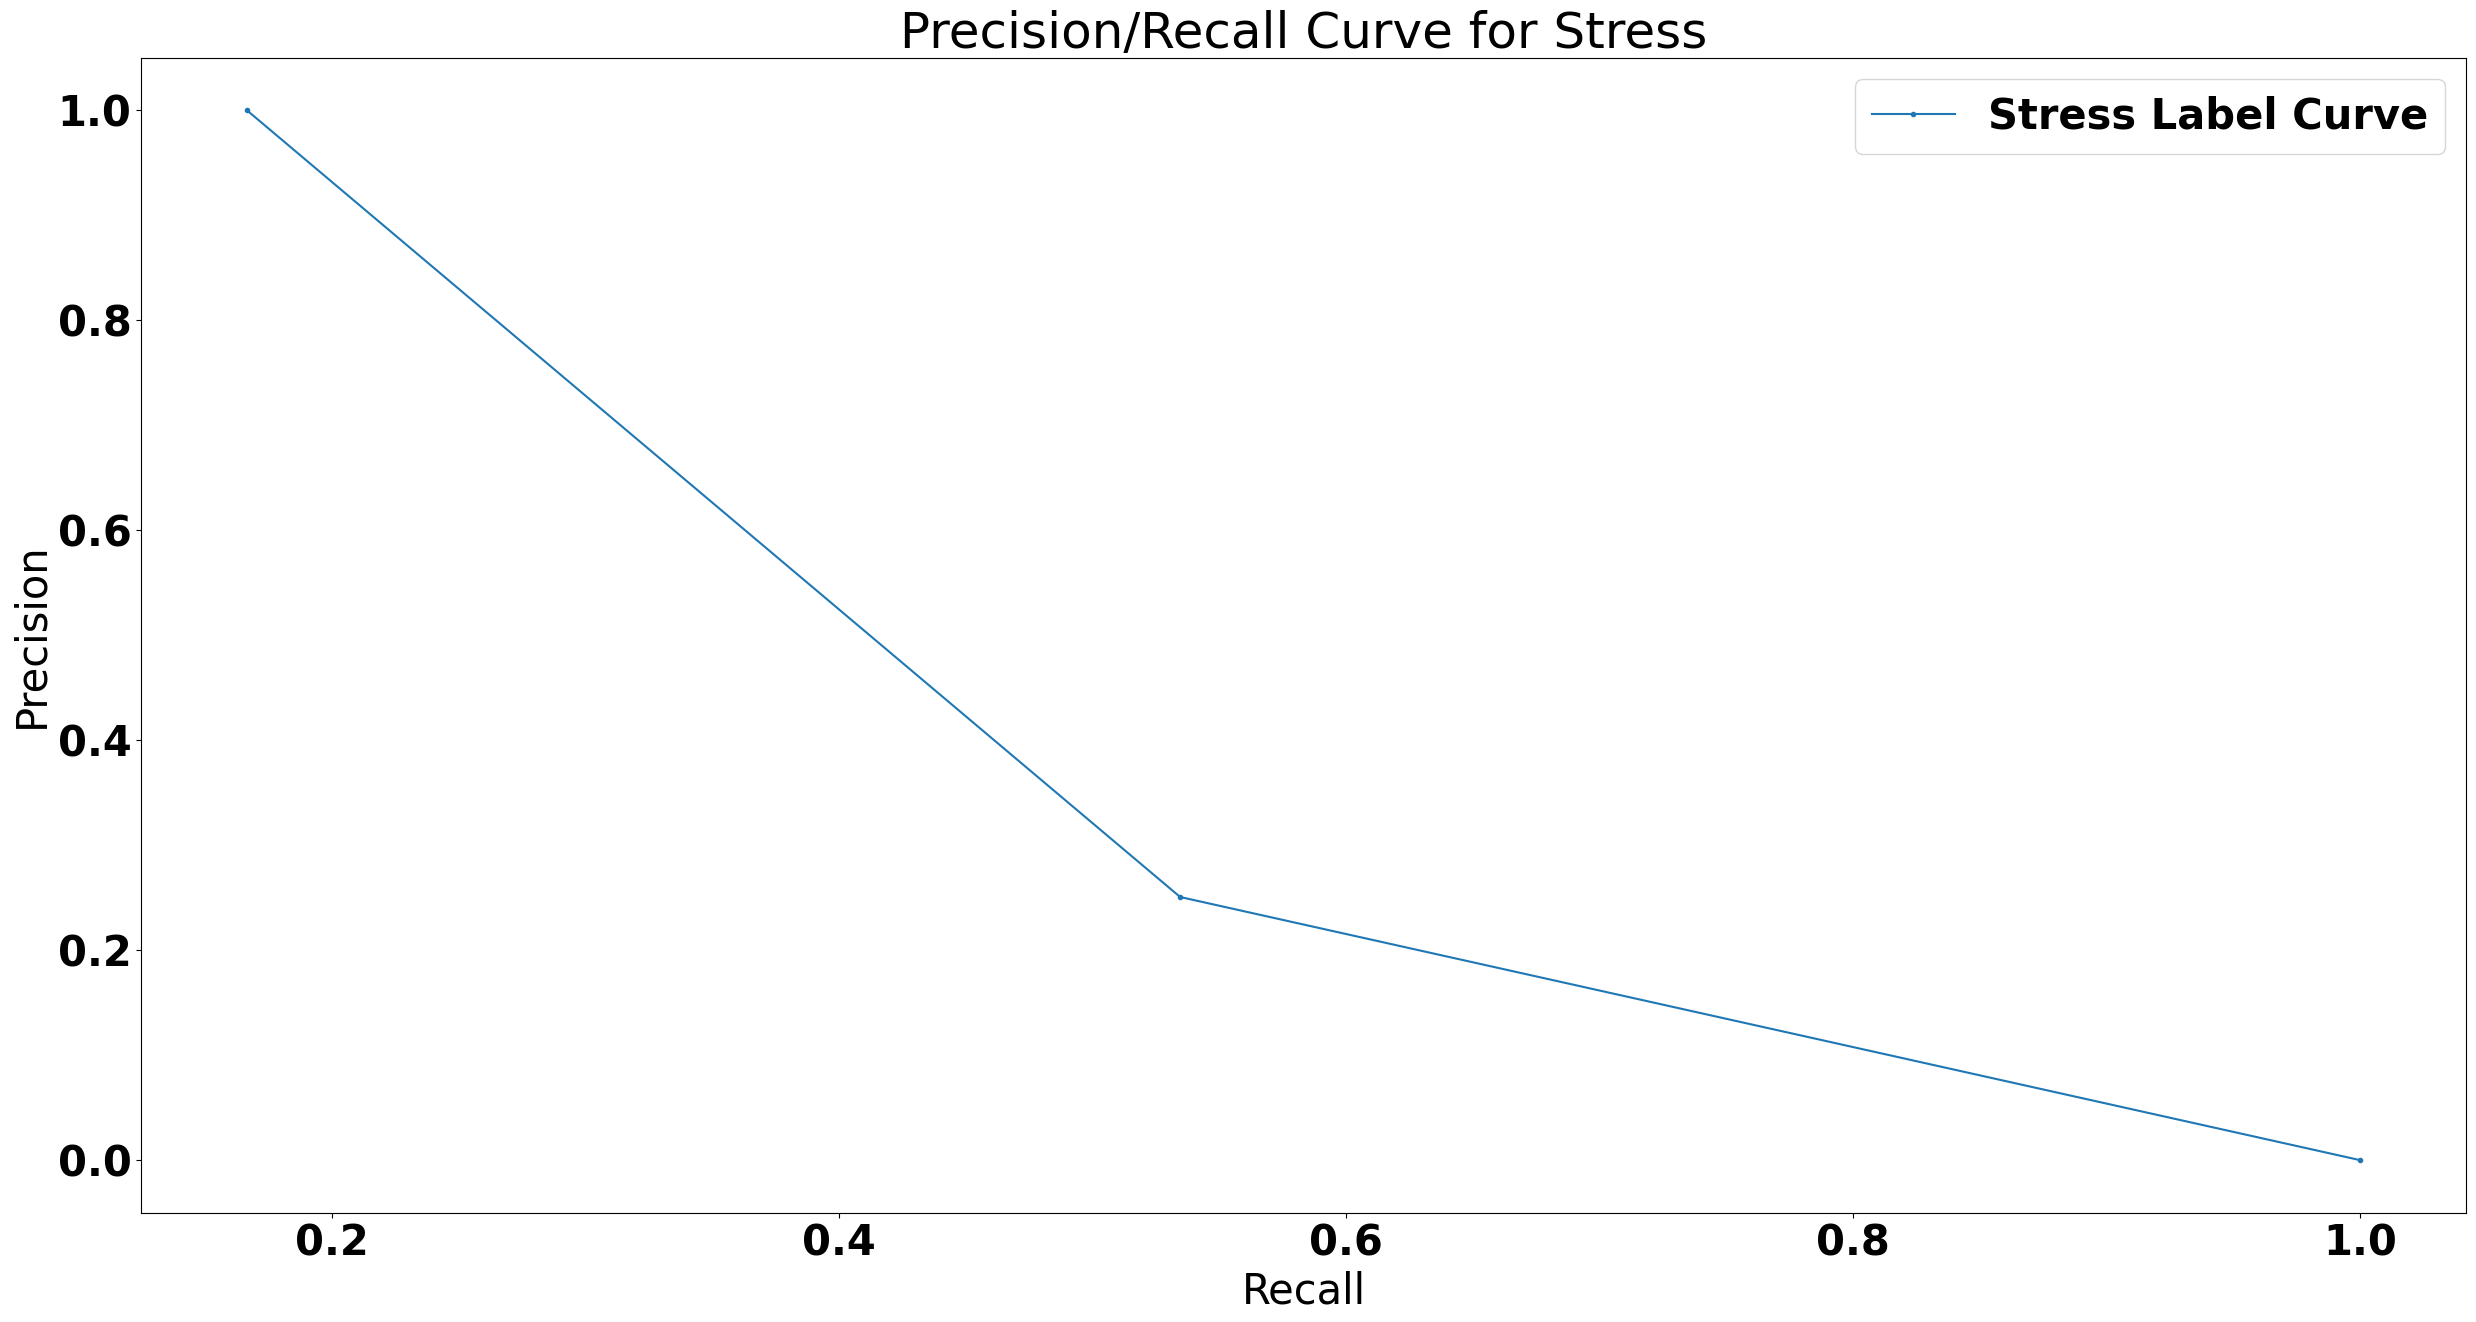

[[1100   14   60]
 [ 131  533   21]
 [ 271    7   93]]
           Baseline  Stress  Amusement
Baseline       1100      14         60
Stress          131     533         21
Amusement       271       7         93


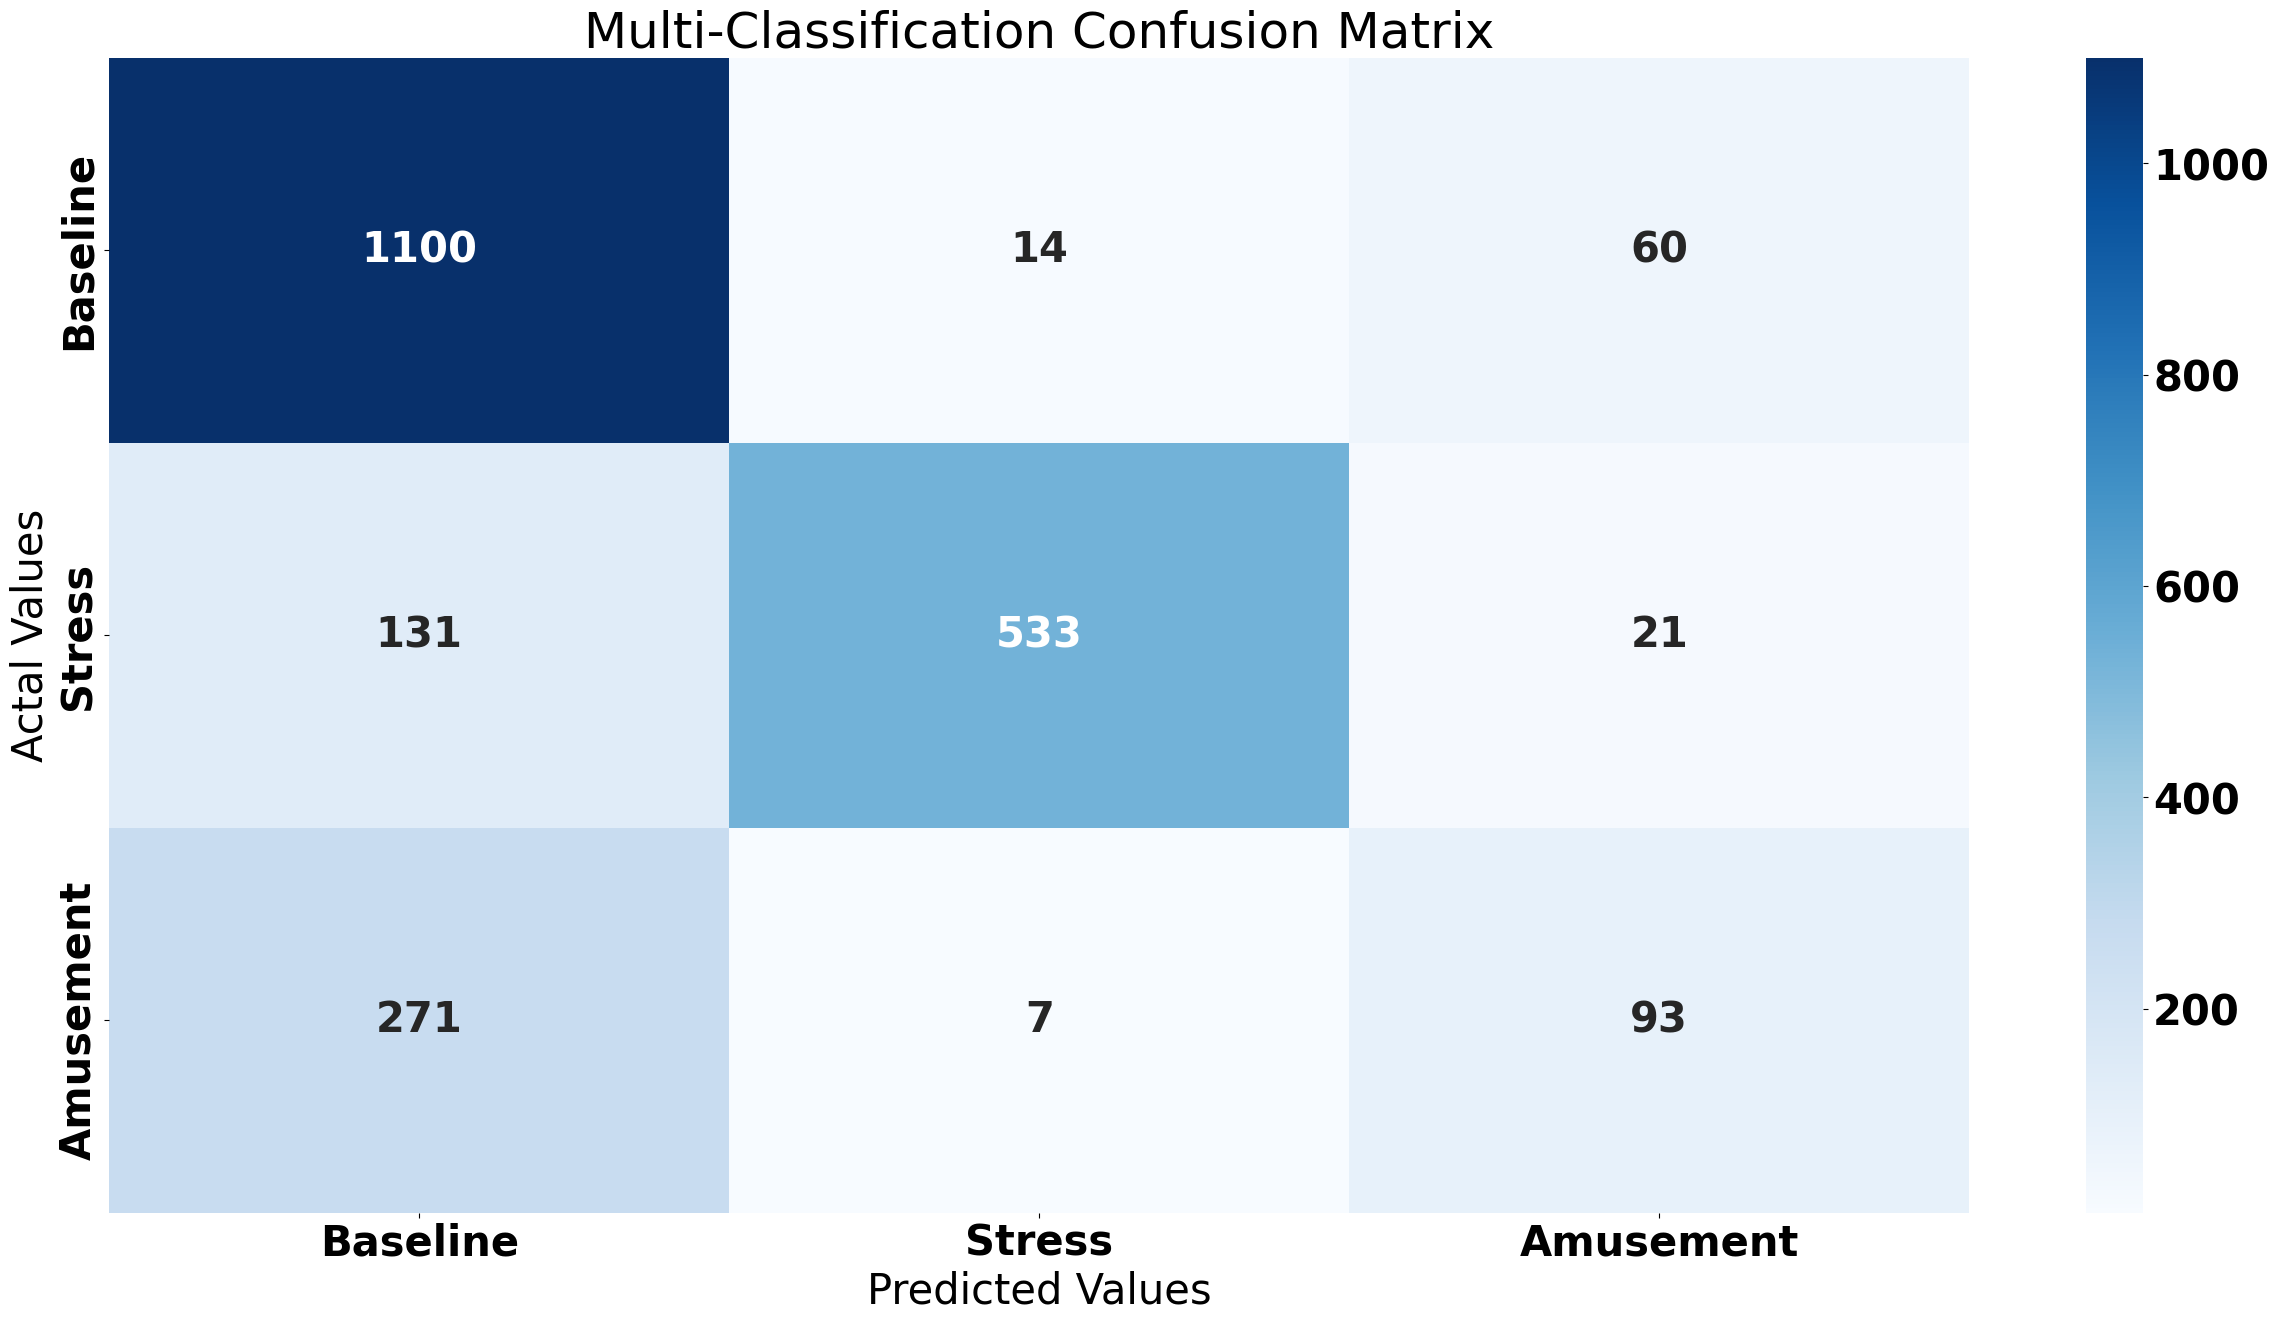

[0 1 2] [1174  685  371]
[0 1 2] [0.5264574  0.30717489 0.16636771]
[0 1 2] [1502  554  174]
[0 1 2] [0.6735426  0.24843049 0.07802691]
Classification Report: 

              precision    recall  f1-score   support

    Baseline       0.73      0.94      0.82      1174
      Stress       0.96      0.78      0.86       685
   Amusement       0.53      0.25      0.34       371

    accuracy                           0.77      2230
   macro avg       0.74      0.66      0.67      2230
weighted avg       0.77      0.77      0.75      2230

Matthews Correlation: 0.615644479483896


In [228]:
font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 30}
plt.rc("font",**font)

y_test = validation_targets

for model_name in models_to_test:
    y_pred_prob = models_to_test[model_name]["model"].predict( x = convert_to_tensor(validation_features) )

    predictions = []
    for i in range(len(y_pred_prob)):
        predictions.append(np.argmax(y_pred_prob[i]))
    
    y_pred = np.array(predictions)
    models_to_test[model_name]["predictions"] = y_pred

    df_y = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_pred
    })

    df_y_stress = df_y.copy()

    df_y_stress["y_test"] = df_y_stress["y_test"].astype("int64")
    for i in range(len(df_y_stress)):
        if df_y_stress.iloc[i]["y_pred"] == 2:
            df_y_stress.iloc[i]["y_pred"] = 1
        else:
            df_y_stress.loc[i]["y_pred"] = 0

        if df_y_stress.iloc[i]["y_test"] == 2:
            df_y_stress.iloc[i]["y_test"] = 1
        else:
            df_y_stress.loc[i]["y_test"] = 0

    stress_roc_score = roc_auc_score(df_y_stress["y_test"], df_y_stress["y_pred"])

    models_to_test[model_name]["pred_image"] = df_y.plot(figsize=(30, 8), grid=True, lw=4).get_figure()
    plt.title(model_name)

    y_test_label = np.array([pacient_state[i] for i in y_test])
    y_pred_label = np.array([pacient_state[i] for i in y_pred])

    print(f"ROC AUC Score for Stress Label: {stress_roc_score} for model: {model_name}")

    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_y_stress["y_test"], df_y_stress["y_pred"])

    gmeans = np.sqrt(true_positive_rate * (1-false_positive_rate))
    ix = np.argmax(gmeans)

    print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]} for model: {model_name}')
    print(f'True Positive Rate for {model_name}: {true_positive_rate}')

    plt.figure(figsize=(30,15))
    plt.title('ROC Curve for Stress')
    plt.plot(false_positive_rate, true_positive_rate, marker='.', label='Stress Label Curve')
    plt.scatter(false_positive_rate[ix], true_positive_rate[ix], marker='o', color='black', label='Best')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(df_y_stress["y_test"], df_y_stress["y_pred"])

    print(f'Recalls Availables for {model_name}: {recall}')

    plt.figure(figsize=(30,15))
    plt.title('Precision/Recall Curve for Stress')
    plt.plot(precision, recall, marker='.', label='Stress Label Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    cm = confusion_matrix(df_y["y_test"].to_list(), df_y["y_pred"].to_list())
    print(cm)
    cm_df = pd.DataFrame(cm, index = labels, columns = labels)
    print(cm_df)

    plt.figure(figsize=(30,15))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    plt.title('Multi-Classification Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

    # multilabel_cm = multilabel_confusion_matrix(y_test_label, y_pred_label, labels=labels)

    # models_to_test[model_name]["confusion_matrix"] = multilabel_cm

    # fig, ax = plt.subplots(1, 3, figsize=(36, 10))

    # for axes, cf_matrix, label in zip(ax.flatten(), multilabel_cm, labels):
    #     print_confusion_matrix(cf_matrix, axes, label, ["N", "Y"])
    # fig.tight_layout()
    # plt.title(model_name)
    
    # models_to_test[model_name]["confusion_matrix_image"] = fig

    unique_values, counts = np.unique(df_y["y_test"], axis=0, return_counts=True)
    print(f"{unique_values} {counts}")
    print(f"{unique_values} {counts/sum(counts)}")

    unique_values, counts = np.unique(df_y["y_pred"], axis=0, return_counts=True)
    print(f"{unique_values} {counts}")
    print(f"{unique_values} {counts/sum(counts)}")

    print(f'Classification Report: \n\n{classification_report(df_y["y_test"], df_y["y_pred"], target_names=labels)}')
    print(f'Matthews Correlation: {matthews_corrcoef(df_y["y_test"], df_y["y_pred"])}')

In [229]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x148b8f7f0>],
  'history': <keras.callbacks.History at 0x14914d880>,
  'model': <keras.engine.sequential.Sequential at 0x148ba9fa0>,
  'predictions': array([2, 2, 2, ..., 1, 1, 1]),
  'pred_image': <Figure size 3000x800 with 1 Axes>},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'nadam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x148b8f430>],
  'history': <keras.callbacks.History at 0x14a16e9a0>,
  'model': <keras.engine.sequential.Sequential at 0x147ac70a0>,
  'predictions': array([2, 0, 0, ..., 1, 1, 1]),
  'pred_image': <Figure size 3000x800 with 1 Axes>},
 'softmax_gru_rmsprop': {'has_activator': True,
  'activator_layer': 'softmax',

## Testing Area

In [230]:
# sigmoid_predictions = models_to_test["sigmoid"]["predictions"]
softmax_predictions = models_to_test["softmax"]["predictions"]
# no_activator_predictions = models_to_test["no_activatior"]["predictions"]

KeyError: 'softmax'

In [ ]:
# sigmoid_predictions
softmax_predictions
# no_activator_predictions

In [ ]:
softmax_predictions.shape

In [ ]:
sum(softmax_predictions[0])

In [ ]:
predictions = []
for i in range(len(softmax_predictions)):
    predictions.append(np.argmax(softmax_predictions[i]))

In [ ]:
len(predictions)

In [ ]:
predictions_array = np.array(predictions)

In [ ]:
predictions_array

In [ ]:
model_targets_validation

In [ ]:
targets_tensor_validation = tf.convert_to_tensor(model_targets_validation, dtype="int64")

In [ ]:
test_loss, test_acc = model.evaluate(features_tensor_validation, targets_tensor_validation, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
df_y = pd.DataFrame({
    "y_test": model_targets_validation,
    "y_pred": predictions_array
})

df_y.head(10)

In [ ]:
df_y.plot(figsize=(30, 8), grid=True)

In [ ]:
np.argmax(no_activator_predictions[0])

In [ ]:
max(no_activator_predictions)

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(range(len(no_activator_predictions)) ,no_activator_predictions)


In [ ]:
# sigmoid_predictions[0]
softmax_predictions[0]

In [ ]:
# sigmoid_predictions[1]
softmax_predictions[1]

In [ ]:
def test_predictions(predictions_test, num_labels):
    label_index_teste = np.argmax(predictions_test[0][:num_labels])
    state_index_teste = np.argmax(predictions_test[0][num_labels:])

    for array in predictions_test:
        if (label_index_teste != np.argmax(array[:num_labels])) and (state_index_teste != np.argmax(array[num_labels:])):
            print("Exist at least one different prediction")
            return
    print("Does not exist different predictions")


In [ ]:
test_predictions(softmax_predictions, num_labels)

In [ ]:
test_predictions(sigmoid_predictions, num_labels)

In [ ]:
test_predictions(no_activator_predictions, num_labels)

In [ ]:
def transform_prediction(prediction_np, num_states, num_labels):
    zeros_base_array = np.zeros(num_labels + num_states)

    label_index = np.argmax(prediction_np[:num_labels])
    state_index = np.argmax(prediction_np[num_labels:])

    zeros_base_array[label_index] = 1
    zeros_base_array[num_labels + state_index] = 1

    return zeros_base_array

In [ ]:
transformed_array_list = []


for prediction in sigmoid_predictions:
    binary_array = transform_prediction(prediction, num_states, num_labels).reshape(1, num_states + num_labels)
    transformed_array_list.append(binary_array)


In [ ]:
fittable_econder_array = np.concatenate(transformed_array_list, axis=0)

In [ ]:
unique_values = np.unique(fittable_econder_array, axis=0)

unique_values

In [ ]:
enc.inverse_transform(fittable_econder_array)

In [ ]:
enc.get_feature_names()

In [ ]:
target_validation_array_list = []

for array in model_targets_validation:
    target_validation_array_list.append(array.reshape(1,14))

target_validation_array = np.concatenate(target_validation_array_list, axis=0)

In [ ]:
target_validation_array

In [ ]:
target_validation_array[0]

In [ ]:
target_validation_array[1]

In [ ]:
unique_values1 = np.unique(target_validation_array, axis=0)

unique_values1

In [ ]:
np.concatenate(target_validation_array_list, axis=0)

In [ ]:
labeled_validation = enc.inverse_transform(model_targets_validation.tolist())

In [ ]:
labeled_validation